# Libraries 

In [47]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import time
from datetime import datetime, timedelta
import plotly.graph_objects as go
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from scipy import stats
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional, LayerNormalization, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import itertools  
from scipy.stats import skew

In [2]:
df =pd.read_excel('E-Commerce Transactions Volume.xlsx')

# DATA PREPROCESSING 

In [48]:
df.head()

Volume  Daily_Change  Pct_Change
date                                        
2018-12-30     456           NaN         NaN
2018-12-31     559         103.0   22.587719
2019-01-01     471         -88.0  -15.742397
2019-01-02     736         265.0   56.263270
2019-01-03     682         -54.0   -7.336957

In [49]:
df.shape


(2365, 3)

In [50]:
# missing data
df.isna().sum().sum()


2

In [51]:
df.columns

Index(['Volume', 'Daily_Change', 'Pct_Change'], dtype='object')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2365 entries, 2018-12-30 to 2025-07-04
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Volume        2365 non-null   int64  
 1   Daily_Change  2364 non-null   float64
 2   Pct_Change    2364 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 138.4 KB


In [53]:
df.rename(columns={'E-Commerce Transactions: Volume': 'Volume'}, inplace=True)
df.rename(columns={'Date': 'date'}, inplace=True)
# Verify
df.head()

Volume  Daily_Change  Pct_Change
date                                        
2018-12-30     456           NaN         NaN
2018-12-31     559         103.0   22.587719
2019-01-01     471         -88.0  -15.742397
2019-01-02     736         265.0   56.263270
2019-01-03     682         -54.0   -7.336957

In [54]:
df['date'] = pd.to_datetime(df['date'])  # ensure it's datetime
df.set_index('date', inplace=True)

#sort by date just in case
df.sort_index(inplace=True)

# Quick check
df.head()

KeyError: 'date'

In [ ]:
df.describe()


Volume
count   2365.000000
mean    1405.074841
std      820.198225
min        9.000000
25%      903.000000
50%     1247.000000
75%     1700.000000
max    14263.000000

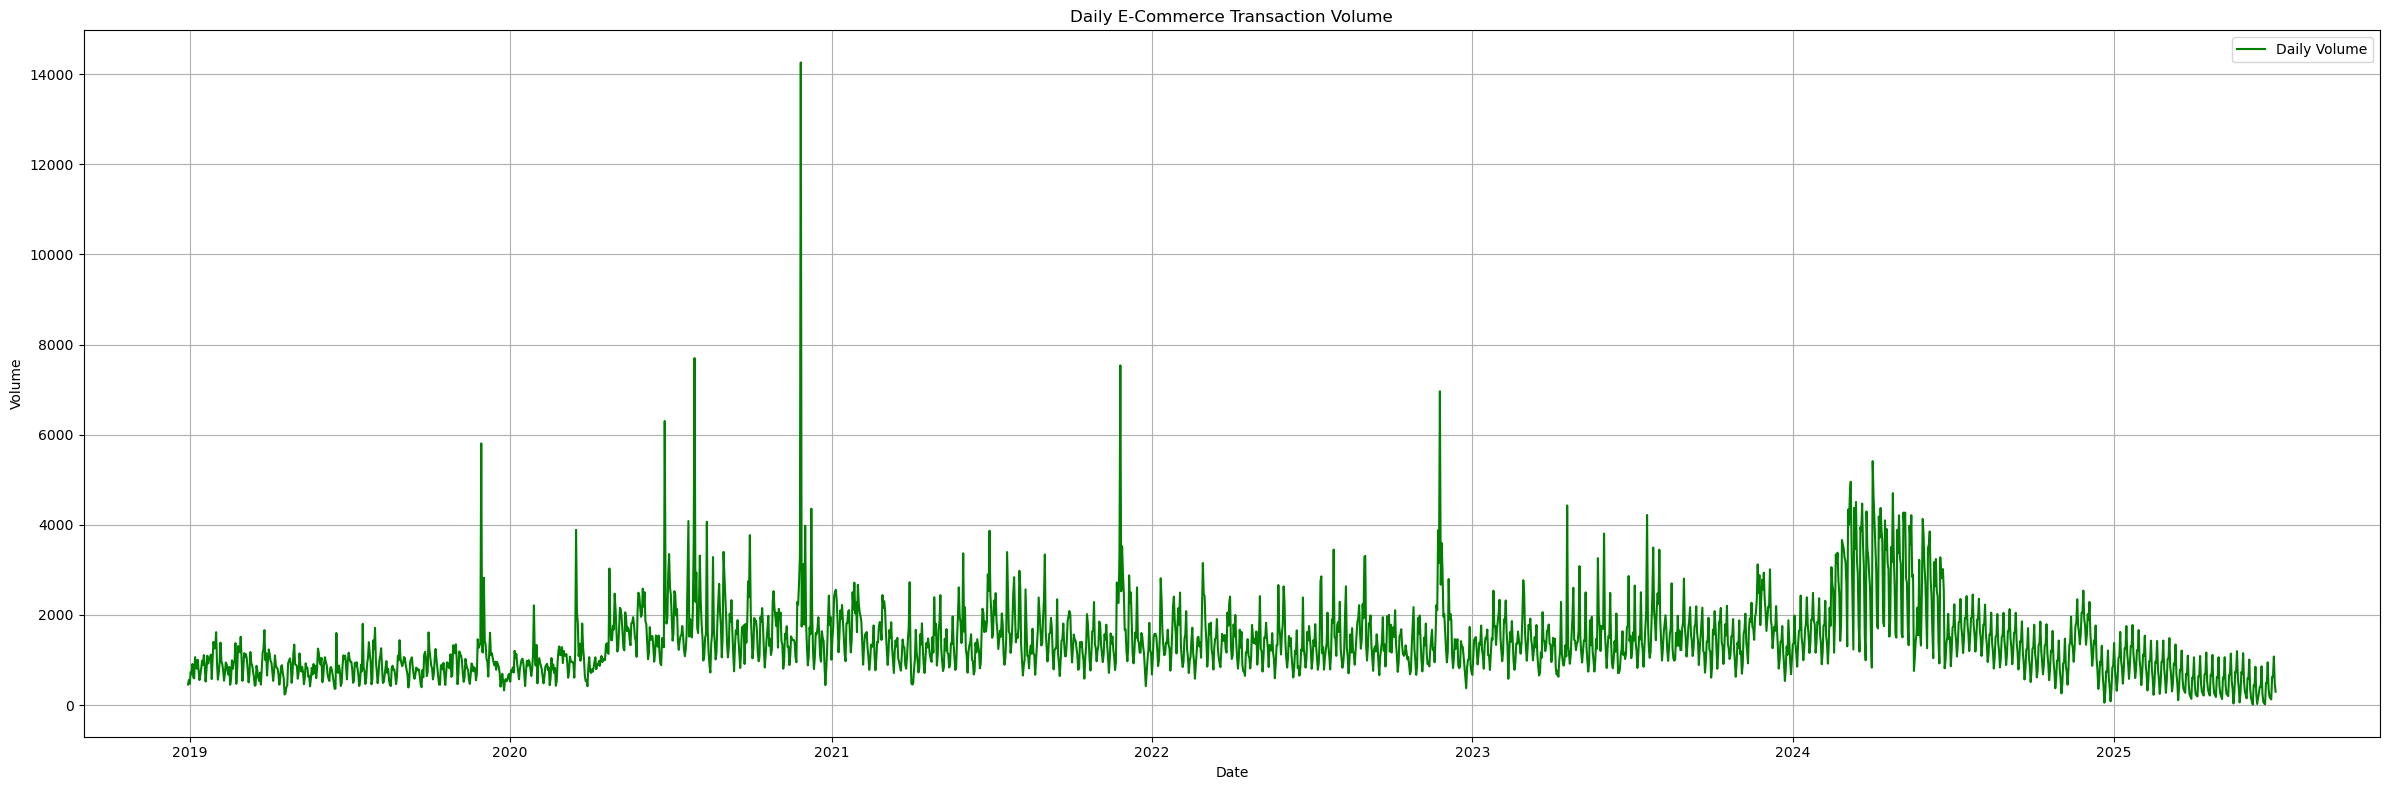

In [ ]:
# Plot side by side
plt.figure(figsize=(24,8))

# Daily plot
plt.plot(df['Volume'], label='Daily Volume', color='green')
plt.title('Daily E-Commerce Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Time span: {(df.index.max() - df.index.min()).days} days")

Date range: 2018-12-30 00:00:00 to 2025-07-04 00:00:00
Time span: 2378 days


In [ ]:
result = adfuller(df['Volume'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] <= 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")


ADF Statistic: -3.197657467532881
p-value: 0.020120675239250693
Critical Values:
   1%: -3.4331512397333626
   5%: -2.8627775348975866
   10%: -2.567428794167024
The time series is stationary


Text(0, 0.5, 'Frequency')

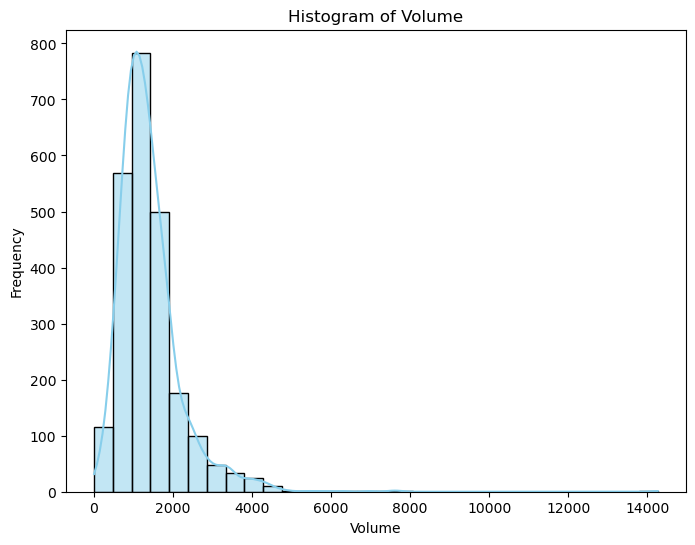

In [ ]:
# Plotting the distribution
# Histogram
plt.figure(figsize=(8,6))
sns.histplot(df['Volume'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')


In [ ]:
# Check distribution after capping
print(f"Skewness of volume: {df['Volume'].skew():.4f}")


Skewness of volume: 3.3083


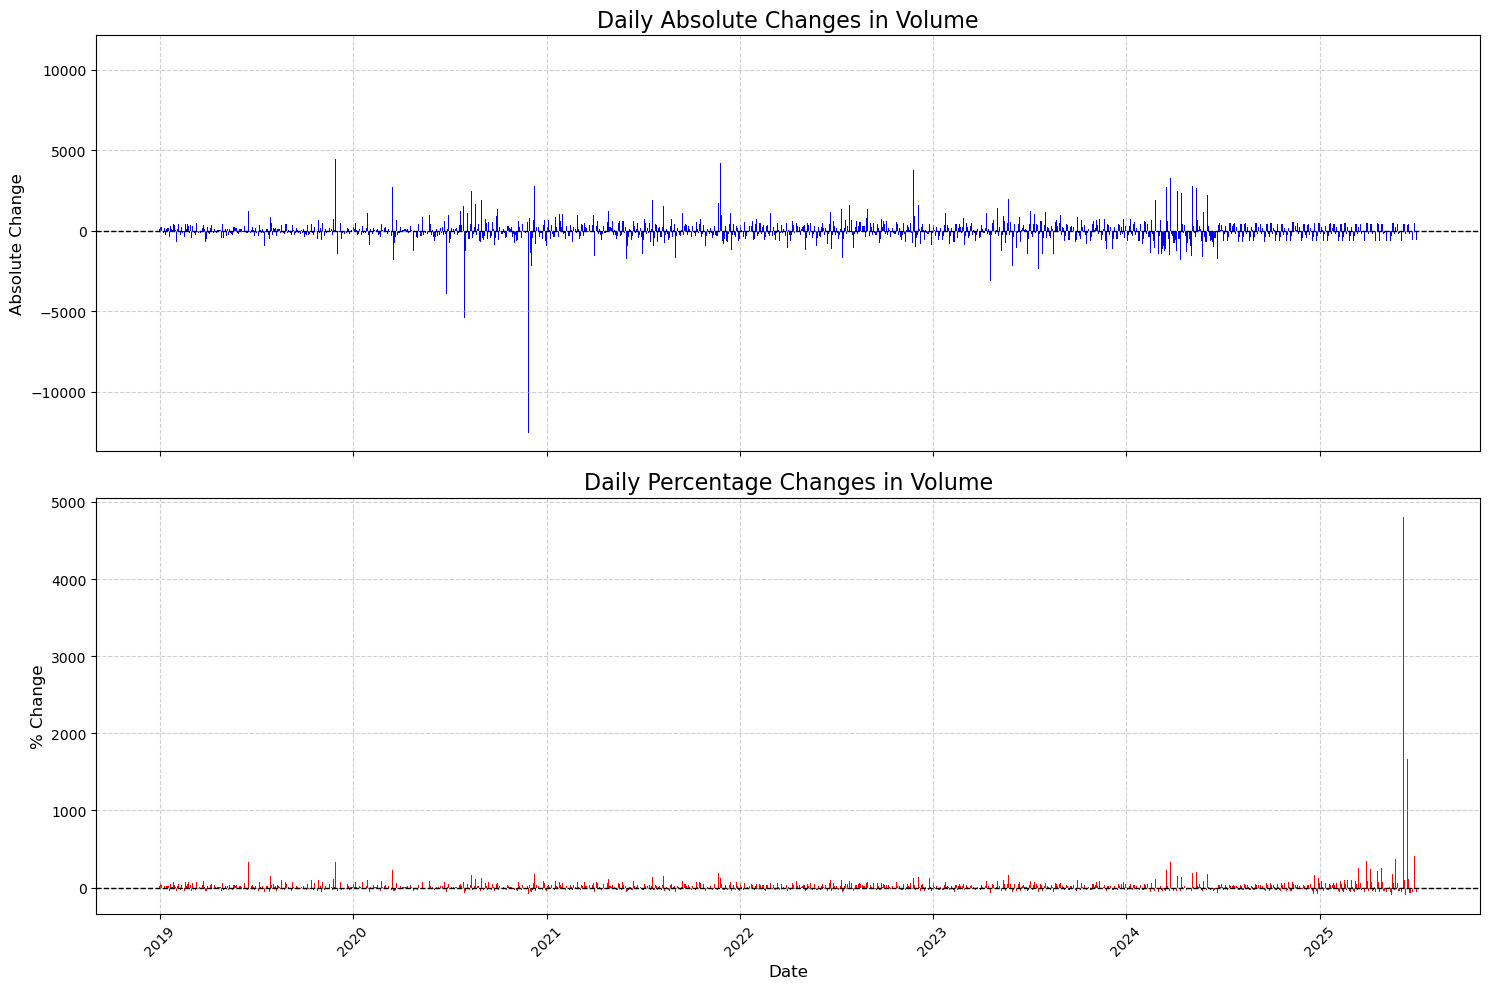

In [ ]:
#-----------------------------------------------
# measuring the day-to-day changes in your Volume
#------------------------------------------------

# --- Calculate changes ---
df['Daily_Change'] = df['Volume'].diff() 

#-----------------------------------------------------------------------------------
# measure how much the Volume changes on a percentage basis from one day to the next
#-----------------------------------------------------------------------------------

df['Pct_Change'] = df['Volume'].pct_change() * 100  # percentage change

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Absolute Change
axes[0].bar(df.index[1:], df['Daily_Change'].dropna(), color='blue', width=1.0)
axes[0].set_title('Daily Absolute Changes in Volume', fontsize=16)
axes[0].set_ylabel('Absolute Change', fontsize=12)
axes[0].axhline(0, color='black', linewidth=1, linestyle='--')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Percentage Change
axes[1].bar(df.index[1:], df['Pct_Change'].dropna(), color='red', width=1.0)
axes[1].set_title('Daily Percentage Changes in Volume', fontsize=16)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('% Change', fontsize=12)
axes[1].axhline(0, color='black', linewidth=1, linestyle='--')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


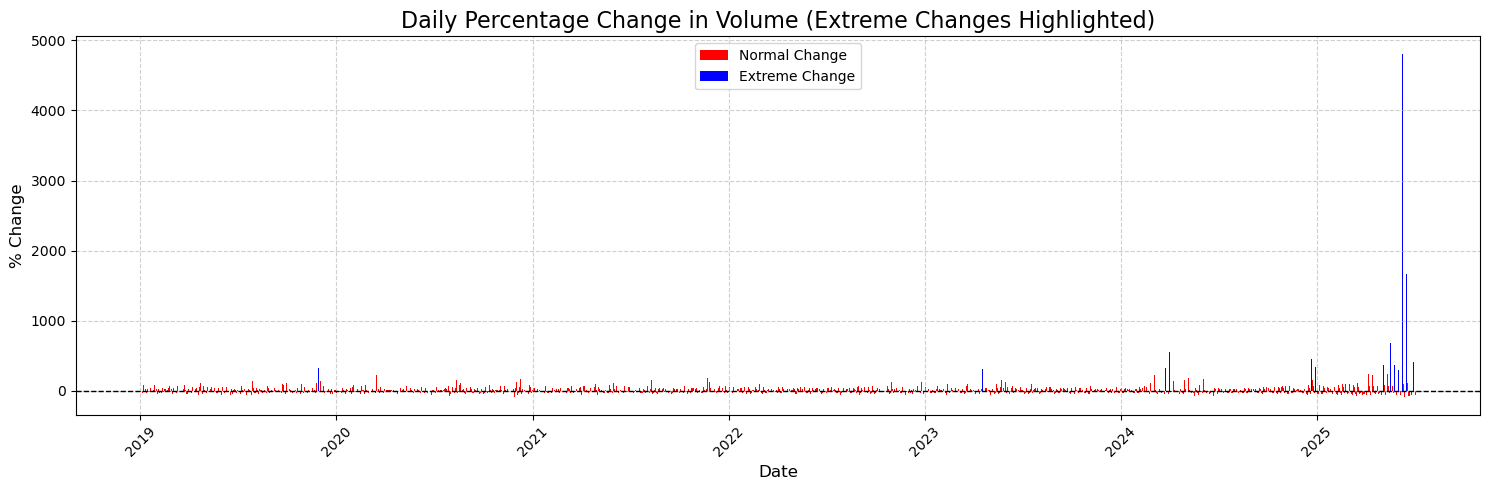

In [ ]:

# Drop the first NaN
pct_change = df['Pct_Change'].dropna()
dates = pct_change.index

# Define extreme change threshold (e.g., 2 std devs)
threshold = 2 * pct_change.std()

# Identify extreme changes
extreme_idx = dates[pct_change.abs() > threshold]

# Plot
plt.figure(figsize=(15, 5))

# Normal changes
plt.bar(dates, pct_change.where(pct_change.abs() <= threshold), 
        color='red', width=1.0, label='Normal Change')

# Extreme changes
plt.bar(extreme_idx, pct_change.loc[extreme_idx], 
        color='blue', width=1.0, label='Extreme Change')

# Reference line
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# Titles and labels
plt.title('Daily Percentage Change in Volume (Extreme Changes Highlighted)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('% Change', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Threshold for extreme changes 
threshold = 2 * pct_change.std()

# Identify extreme changes
extreme_idx = pct_change.abs() > threshold

# Extract extreme dates and values
extreme_df = pd.DataFrame({
    'Date': pct_change.index[extreme_idx],
    'Volume': df.loc[pct_change.index[extreme_idx], 'Volume'],
    'Pct_Change': pct_change[extreme_idx]
})

print(extreme_df)

                 Date  Volume   Pct_Change
date                                      
2019-06-17 2019-06-17    1599   336.885246
2019-11-29 2019-11-29    5807   328.560886
2020-06-25 2020-06-25    6304   392.115535
2020-11-27 2020-11-27   14263   334.053561
2023-04-19 2023-04-19    4430   310.946197
2024-03-25 2024-03-25    4297   332.729104
2024-04-01 2024-04-01    5414   552.289157
2024-12-22 2024-12-22     289   455.769231
2024-12-29 2024-12-29     366   346.341463
2025-03-31 2025-03-31     612   343.478261
2025-05-05 2025-05-05     612   367.175573
2025-05-18 2025-05-18     268   688.235294
2025-05-25 2025-05-25     276   375.862069
2025-06-02 2025-06-02     591   299.324324
2025-06-09 2025-06-09     442  4811.111111
2025-06-16 2025-06-16     405  1660.869565
2025-06-23 2025-06-23     490  3166.666667
2025-06-30 2025-06-30     629   407.258065


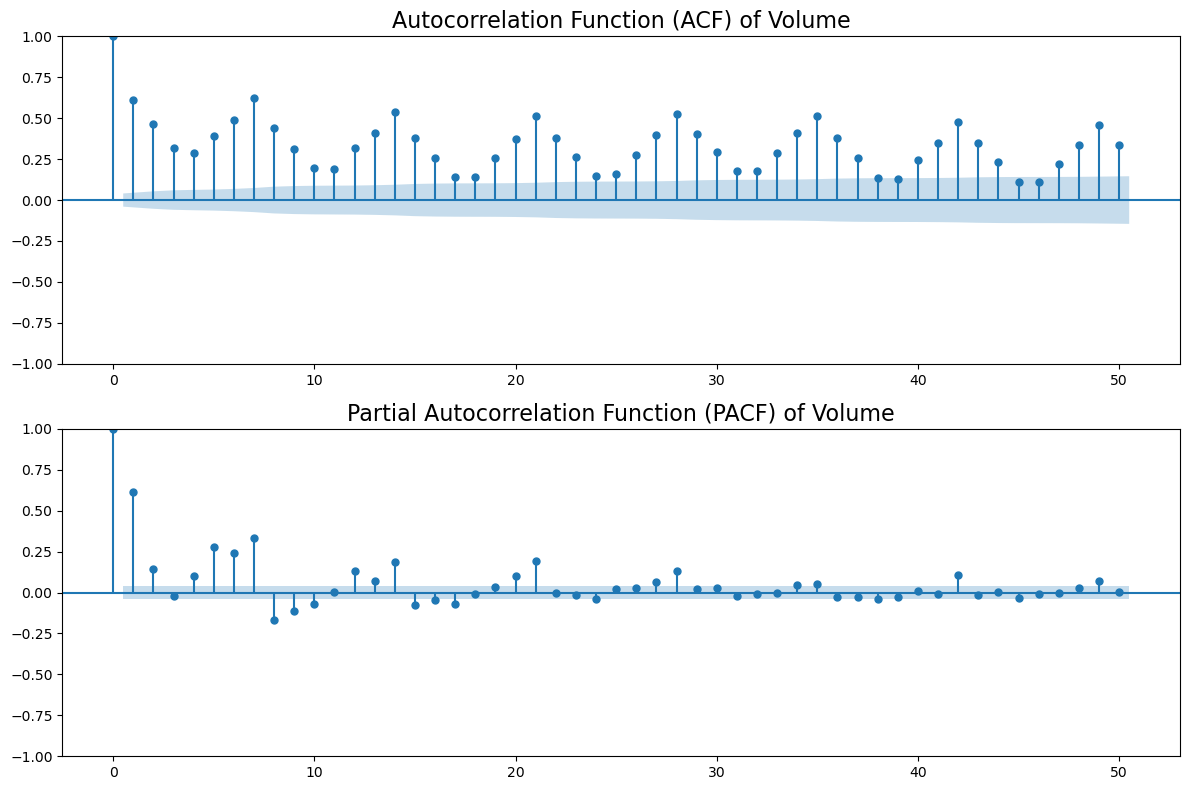

In [ ]:
plt.figure(figsize=(12, 8))

# ACF plot
plt.subplot(2, 1, 1)
plot_acf(df['Volume'], lags=50, ax=plt.gca(), alpha=0.05)  # alpha=0.05 for 95% CI
plt.title('Autocorrelation Function (ACF) of Volume', fontsize=16)

# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(df['Volume'], lags=50, ax=plt.gca(), alpha=0.05, method='ywm')  # method='ywm' avoids warnings
plt.title('Partial Autocorrelation Function (PACF) of Volume', fontsize=16)

plt.tight_layout()
plt.show()


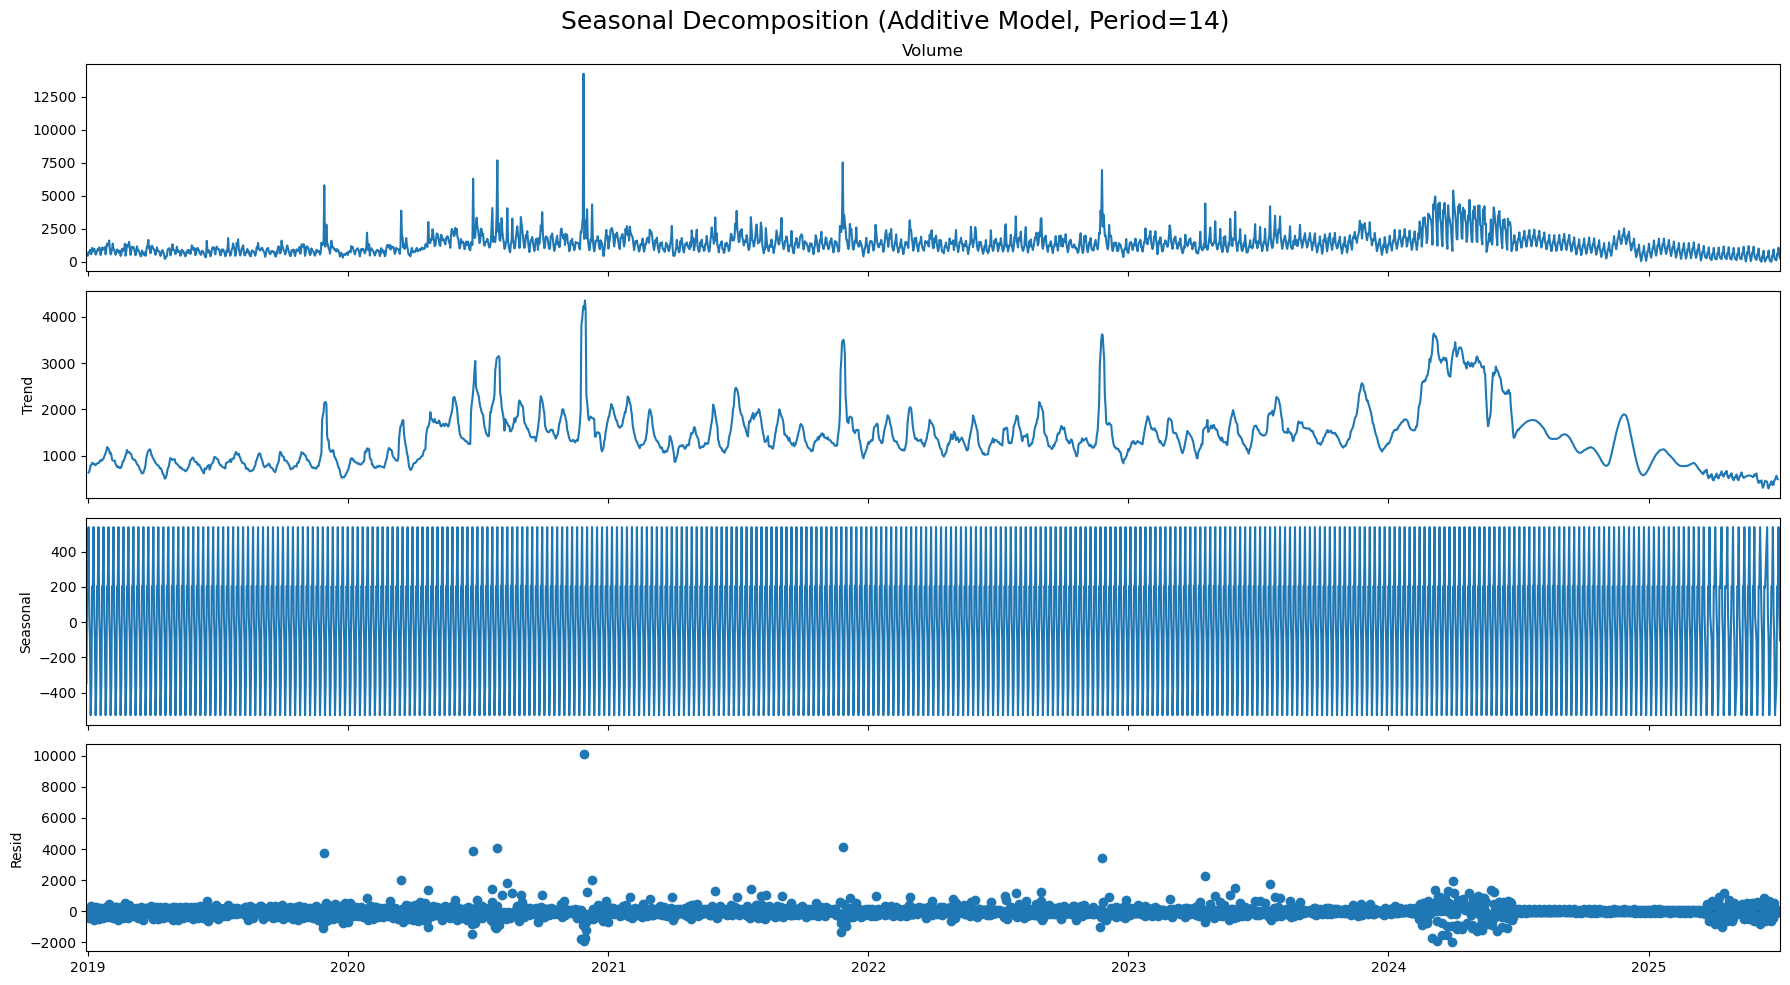

In [ ]:
# Seasonal Decomposition for original data
decomp = seasonal_decompose(df['Volume'], model='additive', period=7)

# Plot decomposition
fig = decomp.plot()
fig.set_size_inches(18, 10)   # set size directly on figure
fig.suptitle("Seasonal Decomposition (Additive Model, Period=14)", fontsize=18)

plt.tight_layout()
plt.show()

In [ ]:
# Drop NaNs from trend to align all components
T = decomp.trend.dropna().values
S = decomp.seasonal[decomp.trend.notna()].values
R = decomp.resid[decomp.trend.notna()].values

# Compute Trend Strength
var_R = np.var(R)
var_T_plus_R = np.var(T + R)
F_T = max(0, 1 - var_R / var_T_plus_R)

# Compute Seasonality Strength
var_S_plus_R = np.var(S + R)
F_S = max(0, 1 - var_R / var_S_plus_R)

print(f"Trend Strength : {F_T:.4f}")
print(f"Seasonality Strength : {F_S:.4f}")

Trend Strength : 0.6664
Seasonality Strength : 0.3740


In [ ]:
print("\n STATISTICAL ANALYSIS ===")

volatility = df['Volume'].std()
mean_value = df['Volume'].mean()
cv = (volatility / mean_value) * 100  # Coefficient of variation // how much values deviate from the average.

mad = np.mean(np.abs(df['Volume'] - mean_value))

print(f"Volatility (Std Dev): {volatility:.2f}")
print(f"Coefficient of Variation: {cv:.2f}%")
print(f"Mean Absolute Deviation: {mad:.2f}")



 STATISTICAL ANALYSIS ===
Volatility (Std Dev): 820.20
Coefficient of Variation: 58.37%
Mean Absolute Deviation: 555.20


In [ ]:
# find the window that captures most of the trend of the actual data  

# Candidate rolling windows in days
windows = [3,7, 14, 30, 60, 90]

# Original trend strength
original_trend_strength =  F_T # ariginal trend strength

print("Rolling Window Trend Strength Comparison:")
for w in windows:
    # Smoothed trend using rolling mean
    smoothed = df['Volume'].rolling(window=w, min_periods=1).mean()
    
    # Trend strength = 1 - (variance of detrended series / variance of original series)
    residual_var = ((df['Volume'] - smoothed)**2).mean()
    trend_strength = 1 - residual_var / df['Volume'].var()
    
    print(f"Window {w}: Trend Strength = {trend_strength:.4f}, Difference from Original = {abs(trend_strength - original_trend_strength):.4f}")


Rolling Window Trend Strength Comparison:
Window 3: Trend Strength = 0.6770, Difference from Original = 0.0106
Window 7: Trend Strength = 0.4939, Difference from Original = 0.1725
Window 14: Trend Strength = 0.4056, Difference from Original = 0.2608
Window 30: Trend Strength = 0.3612, Difference from Original = 0.3051
Window 60: Trend Strength = 0.3145, Difference from Original = 0.3519
Window 90: Trend Strength = 0.2702, Difference from Original = 0.3962


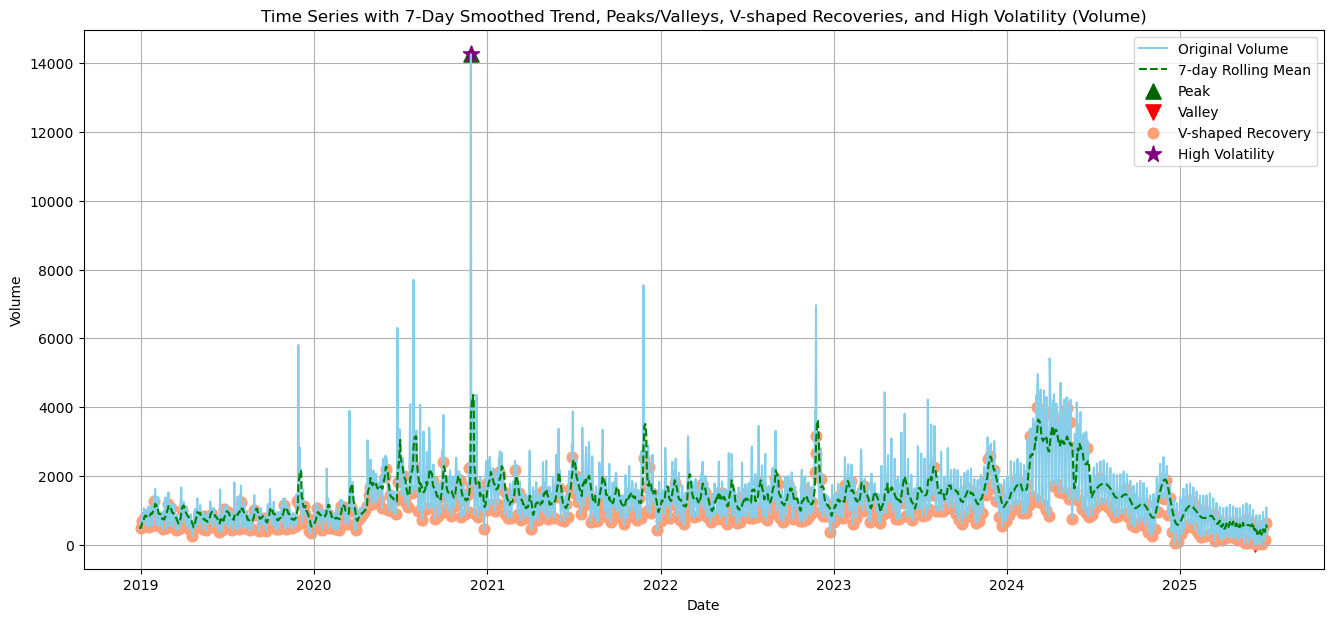

In [ ]:
# --- Smoothed trend ---
rolling_window = 7
smoothed_trend = df['Volume'].rolling(window=rolling_window, min_periods=1).mean()

# --- Peaks and valleys ---
max_val = df['Volume'].max()
min_val = df['Volume'].min()
max_date = df['Volume'].idxmax()
min_date = df['Volume'].idxmin()

# --- V-shaped recoveries ---
v_indices = [i+1 for i in range(len(df)-2) if df['Volume'].iloc[i] > df['Volume'].iloc[i+1] < df['Volume'].iloc[i+2]]
v_values = df['Volume'].iloc[v_indices]

# --- High volatility ---
vol_point = df['Volume'].idxmax() if (max_val - min_val) > df['Volume'].mean() * 0.1 else None

# --- Plot ---
plt.figure(figsize=(16,7))
plt.plot(df.index, df['Volume'], label='Original Volume', color='skyblue')
plt.plot(df.index, smoothed_trend, label=f'7-day Rolling Mean', color='green', linestyle='--')
plt.scatter(max_date, max_val, color='darkgreen', marker='^', s=120, label='Peak')
plt.scatter(min_date, min_val, color='red', marker='v', s=120, label='Valley')
plt.scatter(df.index[v_indices], v_values, color='#FFA07A', marker='o', s=60, label='V-shaped Recovery')

# Corrected high volatility scatter
if vol_point:
    plt.scatter([vol_point], [df.loc[vol_point, 'Volume']], color='purple', marker='*', s=150, label='High Volatility')

plt.title('Time Series with 7-Day Smoothed Trend, Peaks/Valleys, V-shaped Recoveries, and High Volatility (Volume)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.show()


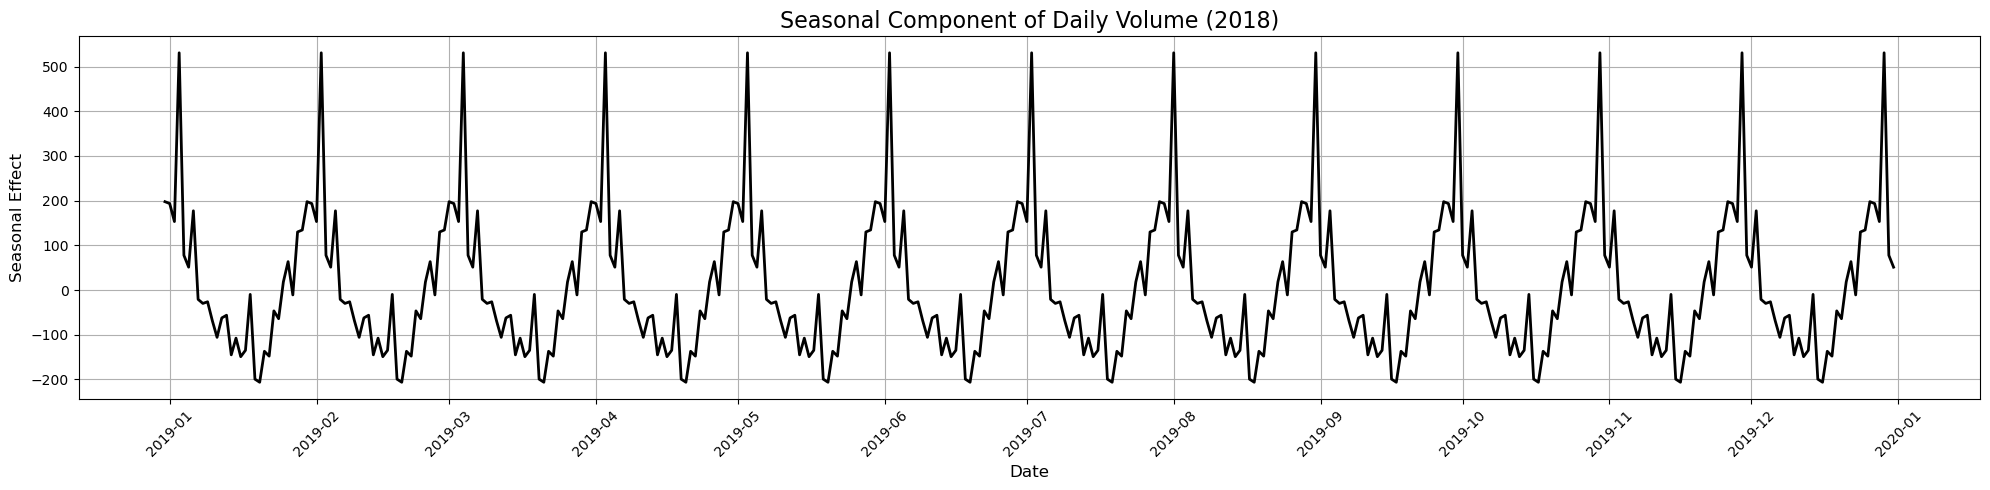

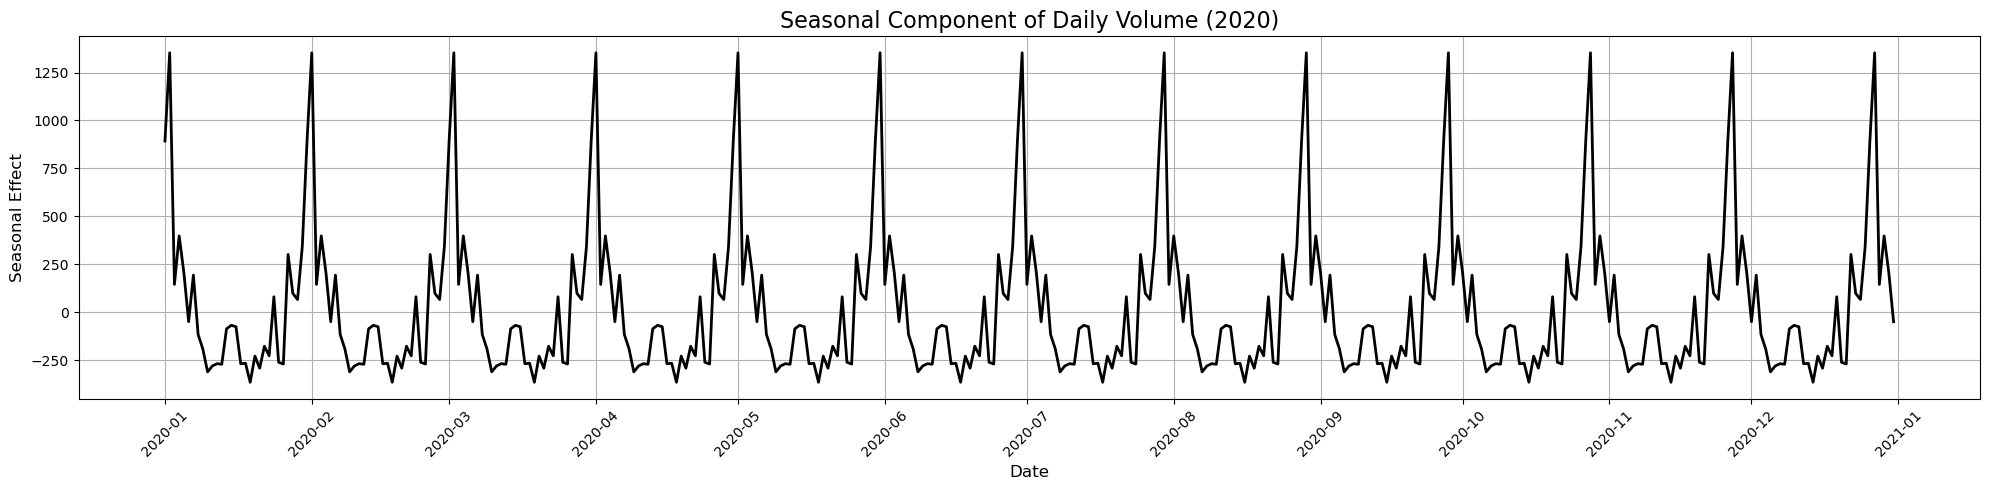

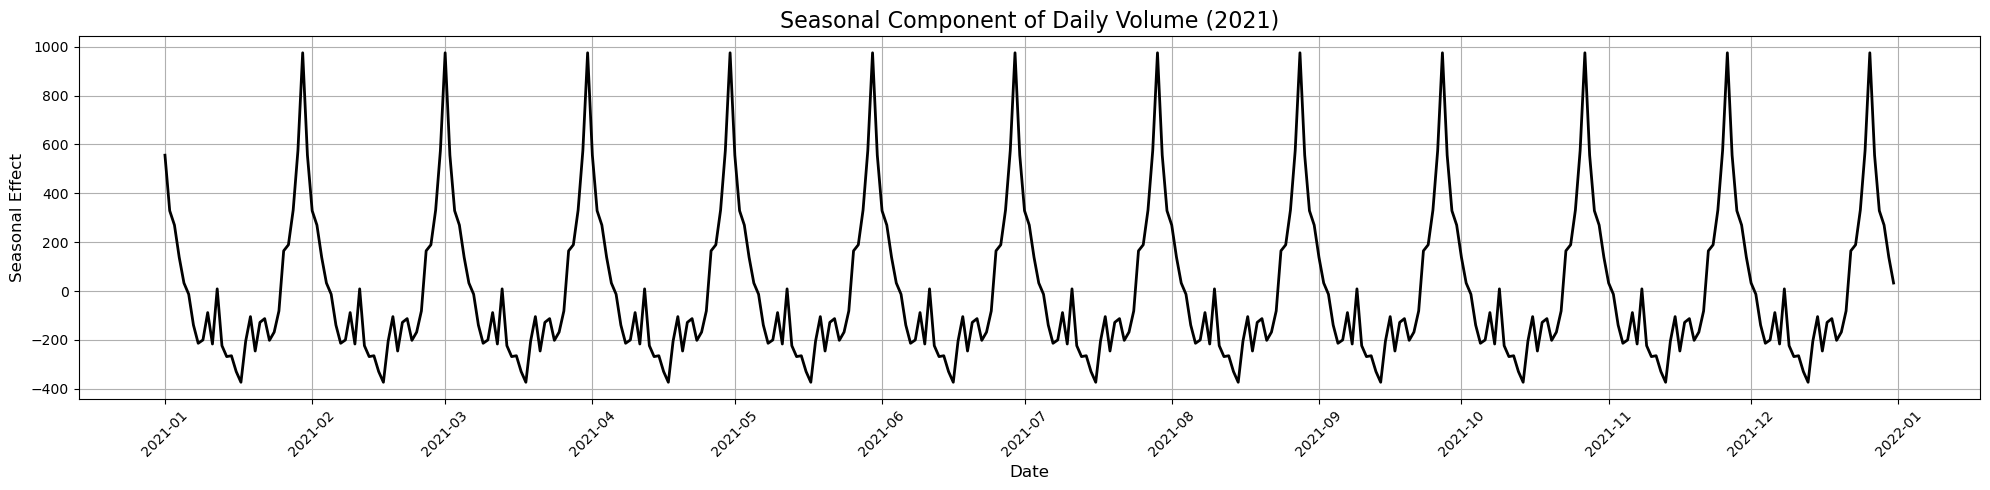

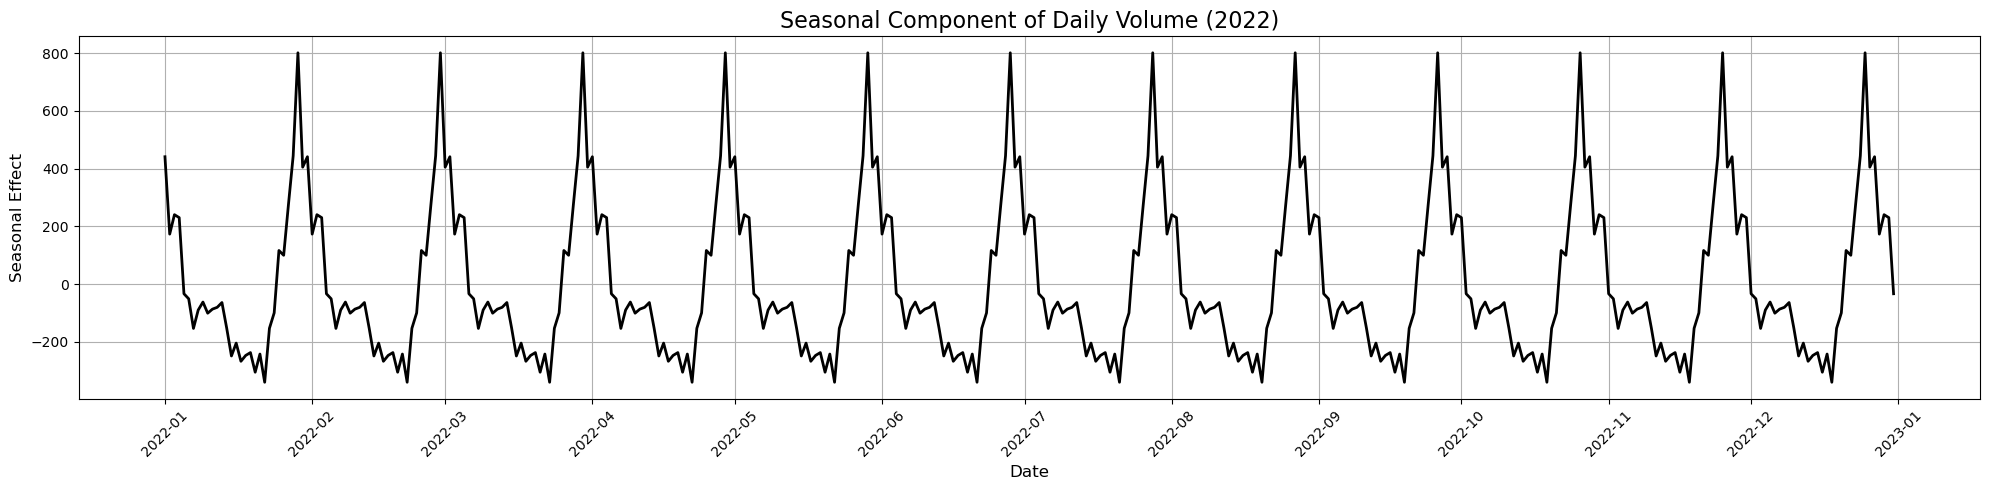

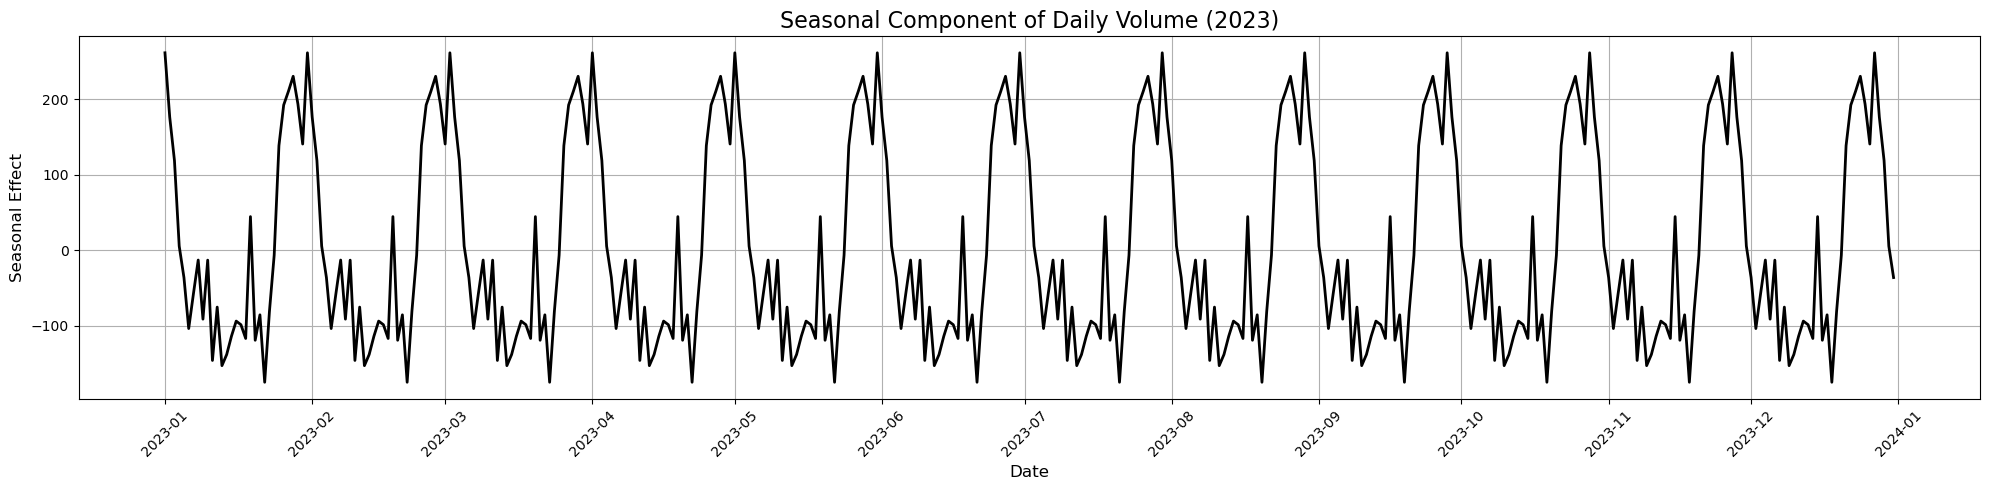

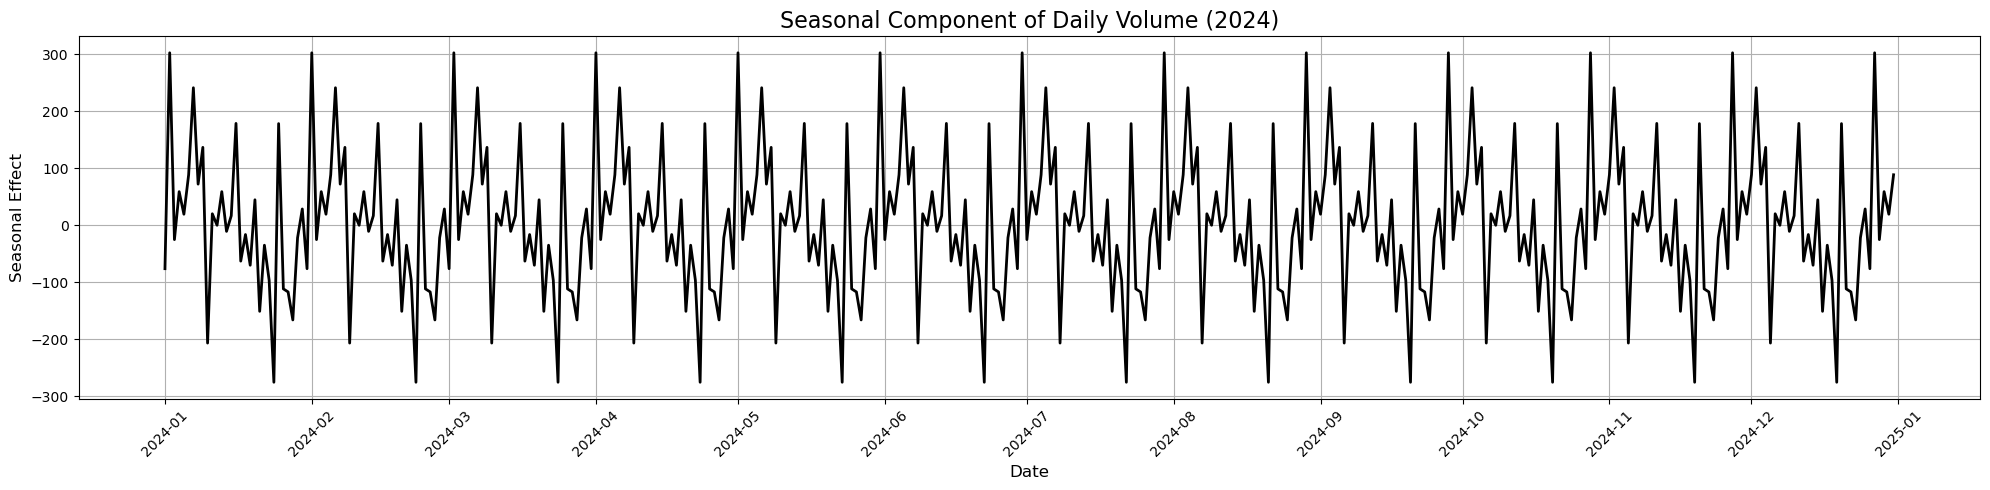

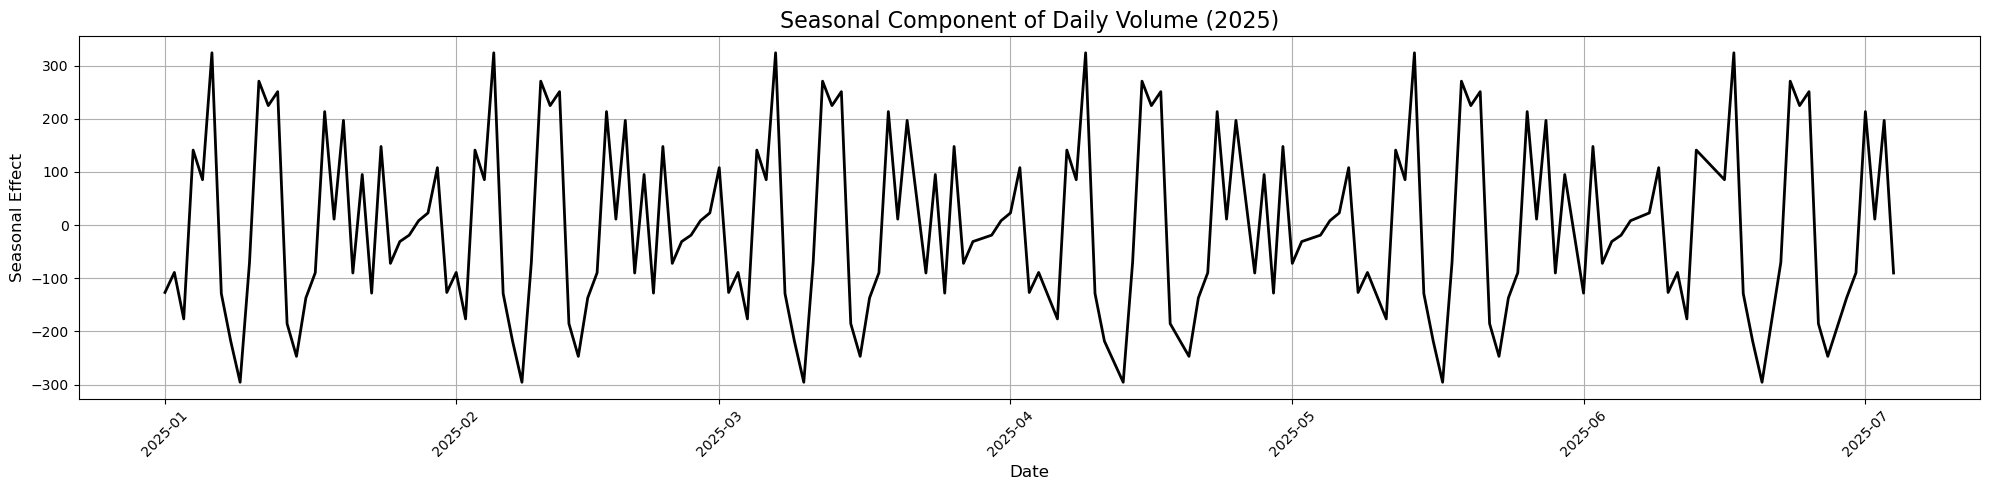

In [ ]:
year_ranges = [
    ('2018-12-31', '2019-12-31'),
    ('2020-01-01', '2020-12-31'),
    ('2021-01-01', '2021-12-31'),
    ('2022-01-01', '2022-12-31'),
    ('2023-01-01', '2023-12-31'),
    ('2024-01-01', '2024-12-31'),
    ('2025-01-01', '2025-12-31')
]

# Loop through each year and plot seasonal component
for start_date, end_date in year_ranges:
    df_subset = df.loc[start_date:end_date]
    
    if len(df_subset) < 30: 
        continue
    
    decompose_subset = seasonal_decompose(df_subset['Volume'], model='additive', period=30)
    seasonal = decompose_subset.seasonal
    
    plt.figure(figsize=(20,5))
    plt.plot(seasonal, color='black', linewidth=2)
    plt.title(f'Seasonal Component of Daily Volume ({start_date[:4]})', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Seasonal Effect', fontsize=12)
    plt.grid(True)
    
    # Format x-axis for months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

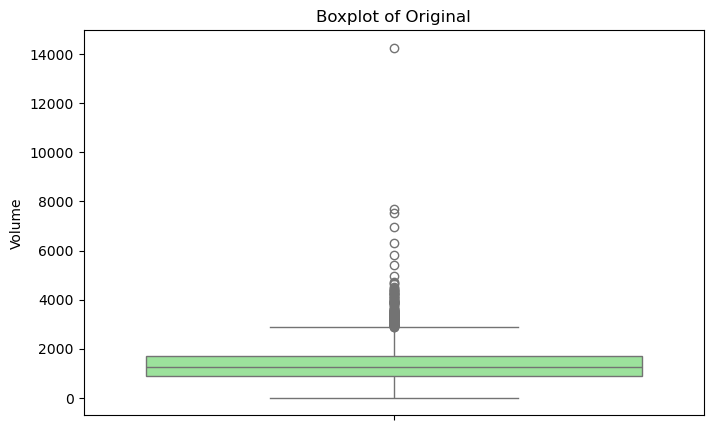

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df['Volume'], palette=["lightgreen"])
plt.title("Boxplot of Original")
plt.ylabel("Volume")
plt.show()


#   EXPLORATORY DATA ANALYSIS

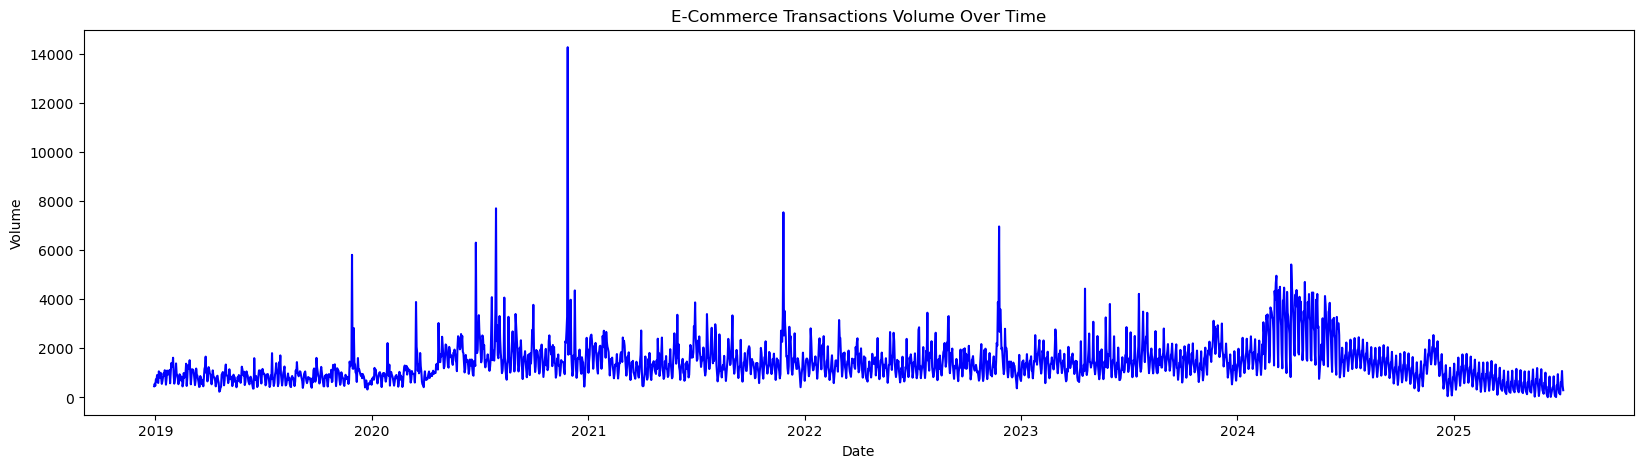

In [55]:
plt.figure(figsize=(20,5))
plt.plot(df['Volume'], color='blue')
plt.title('E-Commerce Transactions Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


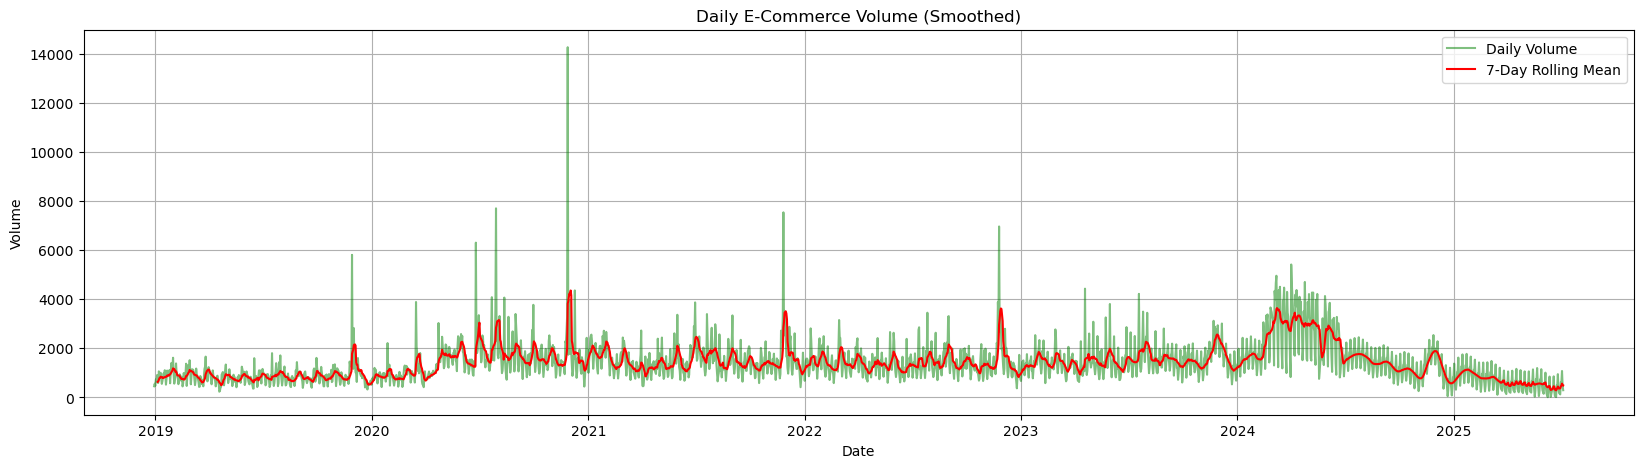

In [56]:
rolling_mean_daily = df['Volume'].rolling(window=7).mean()  # 30-day smoothing

plt.figure(figsize=(20,5))
plt.plot(df['Volume'], color='green', alpha=0.5, label='Daily Volume')
plt.plot(rolling_mean_daily, color='red', label='7-Day Rolling Mean')
plt.title('Daily E-Commerce Volume (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# FEATURE Engeneering

In [36]:
# Make a copy for feature engineering
df_feat = df[['Volume']].copy()


# ---------------------------
#  Lag features
# ---------------------------
   
df_feat['Volume_lag_1'] = df_feat['Volume'].shift(1)
df_feat['Volume_lag_2'] = df_feat['Volume'].shift(1)


# ---------------------------
#  Drop initial rows with NaNs (from lags)
# ---------------------------
df_feat.dropna(inplace=True)

# ---------------------------
# Quick check
# ---------------------------
df_feat.head()


Volume  Volume_lag_1  Volume_lag_2
date                                          
2018-12-31     559         456.0         456.0
2019-01-01     471         559.0         559.0
2019-01-02     736         471.0         471.0
2019-01-03     682         736.0         736.0
2019-01-04     910         682.0         682.0

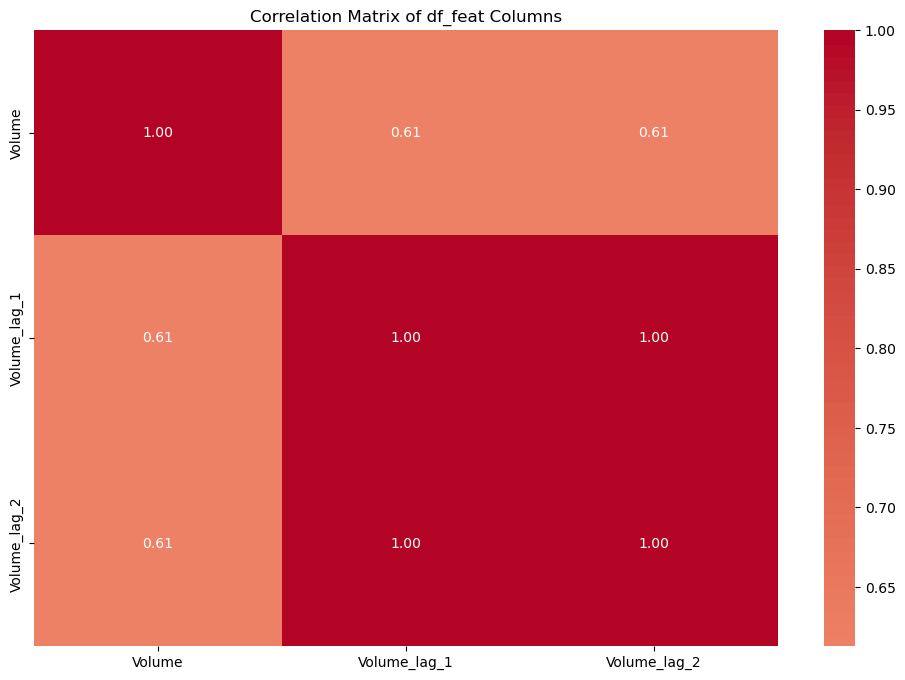

In [37]:
 # Correlation matrix
corr_matrix = df_feat.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of df_feat Columns")
plt.show()

In [38]:
df_feat.columns

Index(['Volume', 'Volume_lag_1', 'Volume_lag_2'], dtype='object')

In [39]:
df_feat.head()

Volume  Volume_lag_1  Volume_lag_2
date                                          
2018-12-31     559         456.0         456.0
2019-01-01     471         559.0         559.0
2019-01-02     736         471.0         471.0
2019-01-03     682         736.0         736.0
2019-01-04     910         682.0         682.0

### spliting

In [40]:
# --- Define target and features ---
target = 'Volume'
features = [col for col in df_feat.columns if col != target]

# --- Chronological splits ---
train_size = int(len(df_feat) * 0.8)  # 80% for train+val
test_size = len(df_feat) - train_size

# Train + Test split (chronologically)
train = df_feat.iloc[:train_size]     # first 80% for training+validation
test = df_feat.iloc[train_size:]      # last 20% for testing

# --- Validation split from within the training set ---
val_split = 0.1
val_size = int(len(train) * val_split)

val = train.iloc[-val_size:]       # last 10% of training data as validation
train = train.iloc[:-val_size]     # remaining 90% as actual training set

# --- Check shapes ---
print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")


Train shape: (1702, 3)
Validation shape: (189, 3)
Test shape: (473, 3)


In [43]:
train_skew = skew(train['Volume'])
val_skew = skew(val['Volume'])
test_skew = skew(test['Volume'])

print(f"Train skewness: {train_skew:.4f}")
print(f"Validation skewness: {val_skew:.4f}")
print(f"Test skewness: {test_skew:.4f}")


Train skewness: 4.9628
Validation skewness: 1.0518
Test skewness: 1.2760


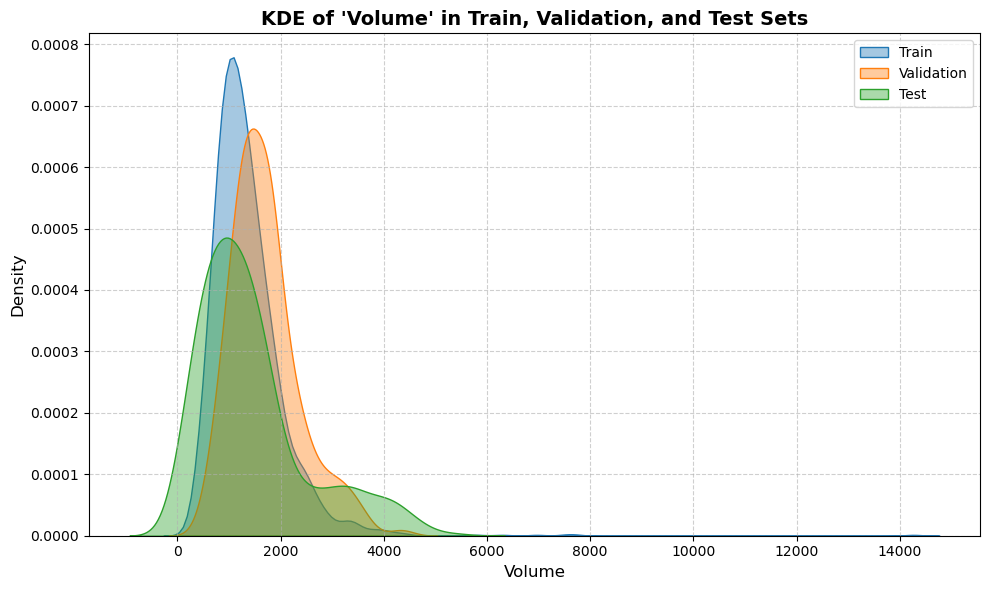

In [44]:
plt.figure(figsize=(10, 6))

# KDE plots for each dataset
sns.kdeplot(train['Volume'], label='Train', fill=True, alpha=0.4)
sns.kdeplot(val['Volume'], label='Validation', fill=True, alpha=0.4)
sns.kdeplot(test['Volume'], label='Test', fill=True, alpha=0.4)

# Titles and labels
plt.title("KDE of 'Volume' in Train, Validation, and Test Sets", fontsize=14, weight='bold')
plt.xlabel("Volume", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [45]:
# --- Causal Winsorization Functions ---

def causal_winsorize(s: pd.Series, window=7, z_thresh=6.0):
    roll_med = s.rolling(window=window, min_periods=1).median()
    roll_mad = (s - roll_med).abs().rolling(window=window, min_periods=1).median() + 1e-9
    z = (s - roll_med) / roll_mad
    return s.where(z.abs() < z_thresh, roll_med)


def causal_from_history(future_df, history_df, cols, window=7, z_thresh=6.0):
    out = {}
    for c in cols:
        joined = pd.concat([history_df[c], future_df[c]])
        capped = causal_winsorize(joined, window=window, z_thresh=z_thresh)
        out[c] = capped.iloc[len(history_df):]  # only take future_df portion
    return pd.DataFrame(out, index=future_df.index)


def safe_target_winsorize(train_series, future_series=None, window=7, z_thresh=6.0):
    roll_med = train_series.rolling(window=window, min_periods=1).median()
    roll_mad = (train_series - roll_med).abs().rolling(window=window, min_periods=1).median() + 1e-9
    z = (train_series - roll_med) / roll_mad
    
    capped_train = train_series.where(z.abs() < z_thresh, roll_med)
    
    capped_future = None
    if future_series is not None:
        last_med = roll_med.iloc[-1]
        last_mad = roll_mad.iloc[-1]
        z_future = (future_series - last_med) / last_mad
        capped_future = future_series.where(z_future.abs() < z_thresh, last_med)
    
    return capped_train, capped_future


In [46]:
# Applies the causal_winsorize function to each predictor column

cols = [c for c in train.columns if c != 	'Volume']  # target separate
train_exog = train[cols].apply(causal_winsorize)


# apply causal winsorization to validation and test sets
val_exog   = causal_from_history(val, train, cols)
test_exog  = causal_from_history(test, pd.concat([train, val]), cols)


# --- Verify shapes ---
print("Train exogenous shape:", train_exog.shape)
print("Validation exogenous shape:", val_exog.shape)
print("Test exogenous shape:", test_exog.shape)

Train exogenous shape: (1702, 2)
Validation exogenous shape: (189, 2)
Test exogenous shape: (473, 2)


In [60]:
# causal winsorization on the target column

# Train target
train_target = train['Volume']

# Validation target
val_target = val['Volume']

# Test target
test_target = test['Volume']

# Apply causal winsorization
train_capped, val_capped = safe_target_winsorize(
    train_series=train_target,
    future_series=val_target,
    window=7,
    z_thresh=6.0
)

# For test, use the last training + validation as history
test_capped = causal_from_history(
    future_df=test[['Volume']],
    history_df=pd.concat([train[['Volume']], val[['Volume']]]),
    cols=['Volume'],
    window=7,
    z_thresh=6.0
)['Volume']


train['Volume_capped'] = train_capped
val['Volume_capped']   = val_capped
test['Volume_capped']  = test_capped


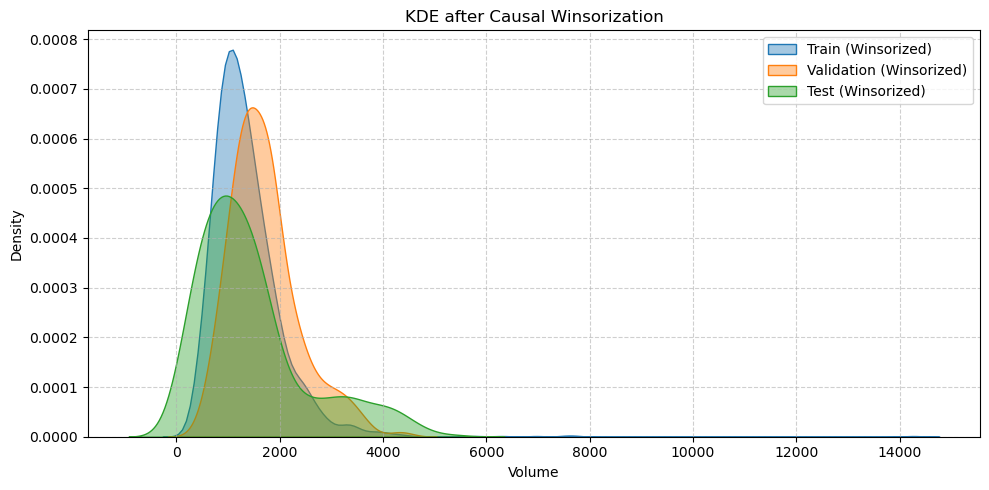

In [61]:

plt.figure(figsize=(10, 5))
sns.kdeplot(train['Volume'], label='Train (Winsorized)', fill=True, alpha=0.4)
sns.kdeplot(val['Volume'], label='Validation (Winsorized)', fill=True, alpha=0.4)
sns.kdeplot(test['Volume'], label='Test (Winsorized)', fill=True, alpha=0.4)

plt.title("KDE after Causal Winsorization")
plt.xlabel("Volume")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [63]:
# ---------------------------
# Rolling mean smoothing 
# ---------------------------

window = 7

# Apply rolling mean on the capped/winsorized 'Value' column
train['Volume_denoised'] = train['Volume_capped'].rolling(window=window, min_periods=1).mean()
val['Volume_denoised']   = val['Volume_capped'].rolling(window=window, min_periods=1).mean()
test['Volume_denoised']  = test['Volume_capped'].rolling(window=window, min_periods=1).mean()

#  quick check
print(train[['Volume', 'Volume_denoised']].head(10))


            Volume  Volume_denoised
date                               
2018-12-31     559       559.000000
2019-01-01     471       515.000000
2019-01-02     736       588.666667
2019-01-03     682       612.000000
2019-01-04     910       671.600000
2019-01-05     612       661.666667
2019-01-06     592       651.714286
2019-01-07    1062       669.285714
2019-01-08     930       734.857143
2019-01-09     806       744.857143


In [64]:
# Skewness
print(f"Skewness - Train: {train['Volume_denoised'].skew():.4f}")
print(f"Skewness - Validation: {val['Volume_denoised'].skew():.4f}")
print(f"Skewness - Test: {test['Volume_denoised'].skew():.4f}")

Skewness - Train: 0.7275
Skewness - Validation: 0.6891
Skewness - Test: 0.9213


In [66]:
# ------------------------------------
# Rolling mean smoothing (predictors)
# ------------------------------------

window = 7  # rolling window size

# --- Denoise training predictors ---
train_exog_denoised = train_exog.rolling(window=window, min_periods=1).mean()

# --- Denoise validation predictors using past history (train + val) ---
val_exog_denoised = pd.concat([train_exog, val_exog]).rolling(window=window, min_periods=1).mean()
val_exog_denoised = val_exog_denoised.iloc[len(train_exog):]  # only keep val portion

# --- Denoise test predictors using past history (train + val + test) ---
test_exog_denoised = pd.concat([train_exog, val_exog, test_exog]).rolling(window=window, min_periods=1).mean()
test_exog_denoised = test_exog_denoised.iloc[len(train_exog) + len(val_exog):]  # only keep test portion

# --- Convert back to DataFrames with original column names ---
train_exog_denoised = pd.DataFrame(train_exog_denoised, index=train.index, columns=cols)
val_exog_denoised   = pd.DataFrame(val_exog_denoised, index=val.index, columns=cols)
test_exog_denoised  = pd.DataFrame(test_exog_denoised, index=test.index, columns=cols)

# --- Quick check ---
print("Train predictors denoised shape:", train_exog_denoised.shape)
print("Validation predictors denoised shape:", val_exog_denoised.shape)
print("Test predictors denoised shape:", test_exog_denoised.shape)


Train predictors denoised shape: (1702, 2)
Validation predictors denoised shape: (189, 2)
Test predictors denoised shape: (473, 2)


In [67]:
test.head()

Volume  Volume_lag_1  Volume_lag_2  Value_capped  Volume_capped  \
date                                                                          
2024-03-05    3995        4339.0        4339.0          3995           3995   
2024-03-06    4661        3995.0        3995.0          4661           4661   
2024-03-07    4956        4661.0        4661.0          4956           4956   
2024-03-08    3507        4956.0        4956.0          3507           3507   
2024-03-09    2328        3507.0        3507.0          2328           2328   

            Volume_denoised  
date                         
2024-03-05      3995.000000  
2024-03-06      4328.000000  
2024-03-07      4537.333333  
2024-03-08      4279.750000  
2024-03-09      3889.400000

In [65]:
# --- Extract predictors from each split ---
train_exog = train[cols]
val_exog   = val[cols]
test_exog  = test[cols]

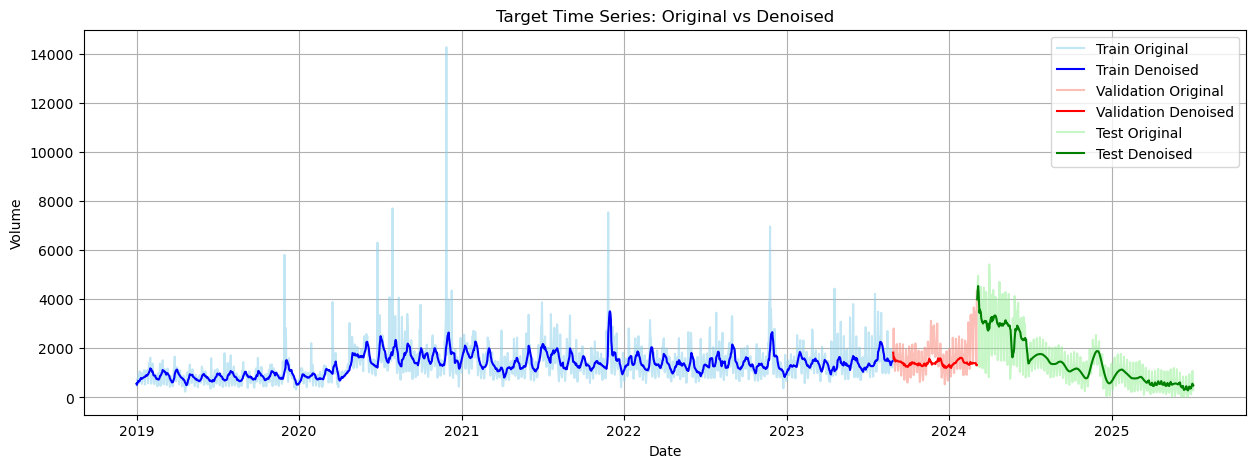

In [69]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['Volume'], label='Train Original', color='skyblue', alpha=0.5)
plt.plot(train.index, train['Volume_denoised'], label='Train Denoised', color='blue')

plt.plot(val.index, val['Volume'], label='Validation Original', color='salmon', alpha=0.5)
plt.plot(val.index, val['Volume_denoised'], label='Validation Denoised', color='red')

plt.plot(test.index, test['Volume'], label='Test Original', color='lightgreen', alpha=0.5)
plt.plot(test.index, test['Volume_denoised'], label='Test Denoised', color='green')

plt.title('Target Time Series: Original vs Denoised')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
cols_to_drop = ['Volume','Volume_capped']

train = train.drop(columns=[c for c in cols_to_drop if c in train.columns])
val   = val.drop(columns=[c for c in cols_to_drop if c in val.columns])
test  = test.drop(columns=[c for c in cols_to_drop if c in test.columns])

# Verify
print("Train columns:", train.columns)
print("Validation columns:", val.columns)
print("Test columns:", test.columns)

Train columns: Index(['Volume_lag_1', 'Volume_lag_2', 'Volume_denoised'], dtype='object')
Validation columns: Index(['Volume_lag_1', 'Volume_lag_2', 'Volume_denoised'], dtype='object')
Test columns: Index(['Volume_lag_1', 'Volume_lag_2', 'Value_capped', 'Volume_denoised'], dtype='object')


In [71]:
# Function to check stationarity
def check_stationarity(series, series_name='Series'):
    result = adfuller(series.dropna())
    print(f"ADF Test for {series_name}:")
    print(f"ADF Statistic: {result[0]}")
    #print(f"p-value: {result[1]}")
    #print("Critical Values:")
    for key, value in result[4].items():
       print(f"   {key}: {value}")
    if result[1] < 0.05:
        print(f"Result: {series_name} is stationary \n")
    else:
        print(f"Result: {series_name} is non-stationary \n")

# Check stationarity for train, validation, and test sets
datasets = [('Train', train), ('Validation', val), ('Test', test)]

for name, df in datasets:
    check_stationarity(df['Volume_denoised'], f"{name} Denoised")

ADF Test for Train Denoised:
ADF Statistic: -3.225867179451586
   1%: -3.4342507300744147
   5%: -2.863262951722777
   10%: -2.5676872561165305
Result: Train Denoised is stationary 

ADF Test for Validation Denoised:
ADF Statistic: -3.2626277042342955
   1%: -3.4685016947910636
   5%: -2.8782983668563396
   10%: -2.57570415906989
Result: Validation Denoised is stationary 

ADF Test for Test Denoised:
ADF Statistic: -1.8562496305852172
   1%: -3.444836032925901
   5%: -2.8679272692747415
   10%: -2.5701721745036776
Result: Test Denoised is non-stationary 



In [72]:
# --- Initialize MinMaxScalers ---
scaler_X = MinMaxScaler().fit(train_exog_denoised)
scaler_y = MinMaxScaler().fit(train[['Volume_denoised']])

# --- Transform predictors ---
X_train = scaler_X.transform(train_exog_denoised)
X_val   = scaler_X.transform(val_exog_denoised)
X_test  = scaler_X.transform(test_exog_denoised)

# --- Transform target ---
y_train = scaler_y.transform(train[['Volume_denoised']])
y_val   = scaler_y.transform(val[['Volume_denoised']])
y_test  = scaler_y.transform(test[['Volume_denoised']])

# --- Print shapes ---
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1702, 2)
y_train shape: (1702, 1)
X_val shape: (189, 2)
y_val shape: (189, 1)
X_test shape: (473, 2)
y_test shape: (473, 1)


In [73]:
X_train_df = pd.DataFrame(X_train, index=train.index, columns=cols)
X_val_df   = pd.DataFrame(X_val,   index=val.index,   columns=cols)
X_test_df  = pd.DataFrame(X_test,  index=test.index,  columns=cols)

y_train_df = pd.DataFrame(y_train, index=train.index, columns=['Volume_denoised'])
y_val_df   = pd.DataFrame(y_val,   index=val.index,   columns=['Volume_denoised'])
y_test_df  = pd.DataFrame(y_test,  index=test.index,  columns=['Volume_denoised'])


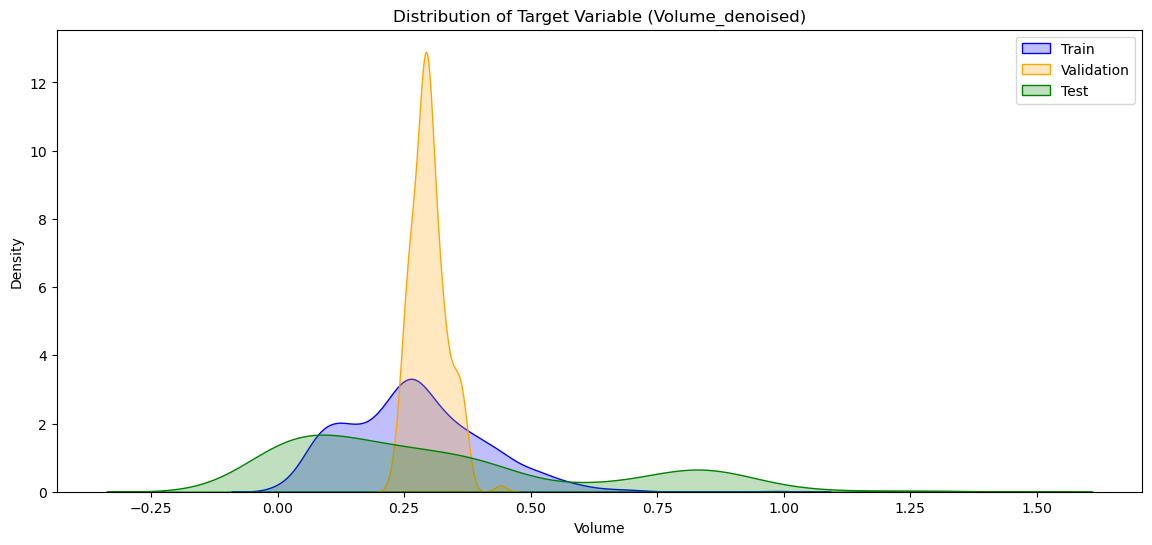

Skewness - Train: 0.7275
Skewness - Validation: 0.6891
Skewness - Test: 0.9213


In [74]:

plt.figure(figsize=(14,6))

sns.kdeplot(y_train_df['Volume_denoised'], color='blue', label='Train', fill=True)
sns.kdeplot(y_val_df['Volume_denoised'], color='orange', label='Validation', fill=True)
sns.kdeplot(y_test_df['Volume_denoised'], color='green', label='Test', fill=True)

plt.title("Distribution of Target Variable (Volume_denoised)")
plt.xlabel("Volume")
plt.ylabel("Density")
plt.legend()
plt.show()

# Skewness
print(f"Skewness - Train: {y_train_df['Volume_denoised'].skew():.4f}")
print(f"Skewness - Validation: {y_val_df['Volume_denoised'].skew():.4f}")
print(f"Skewness - Test: {y_test_df['Volume_denoised'].skew():.4f}")

In [75]:
# Create sequences using past seq_length steps to predict current step


def create_sequences(X, y, seq_length=7):
    """
    Create LSTM sequences using past seq_length steps to predict current step.
    Keeps original indices for alignment.

    Parameters:
    X : pd.DataFrame, features
    y : pd.DataFrame or Series, target
    seq_length : int, number of past timesteps

    Returns:
    X_seq : np.array, shape (num_sequences, seq_length, n_features)
    y_seq : np.array, shape (num_sequences, 1)
    seq_index : np.array, indices of y corresponding to each sequence
    """
    X_seq, y_seq, seq_index = [], [], []

    for i in range(seq_length, len(X)):
        # Take past seq_length steps of features
        X_seq.append(X.iloc[i-seq_length:i].values)

        # Take target at current time step
        y_seq.append(y.iloc[i].values if y.ndim > 1 else y.iloc[i])

        # Store the corresponding index
        seq_index.append(X.index[i])

    return np.array(X_seq), np.array(y_seq), np.array(seq_index)


In [76]:
SEQ_LENGTH = 7  # Using past 7 days to predict next day

X_train_seq, y_train_seq, idx_train_seq = create_sequences(X_train_df, y_train_df, SEQ_LENGTH)
X_val_seq, y_val_seq, idx_val_seq       = create_sequences(X_val_df, y_val_df, SEQ_LENGTH)
X_test_seq, y_test_seq, idx_test_seq    = create_sequences(X_test_df, y_test_df, SEQ_LENGTH)

# Print shapes
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("Number of indices:", len(idx_train_seq))

X_train_seq shape: (1695, 7, 2)
y_train_seq shape: (1695, 1)
Number of indices: 1695


In [77]:
# HELPING FUCTIONS

# training history ploting function
def plot_history(histories, names):
    plt.figure(figsize=(18,6))
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{names[i]} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{names[i]} Val Loss', linestyle='--')
    plt.title('Deep Learning Model Training History (MSE Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# orediction ploting function
def plot_predictions(idx_val, y_val_true, y_val_pred,
                     idx_test, y_test_true, y_test_pred,
                     title='Model Predictions vs True Values'):
    plt.figure(figsize=(16,6))

    # Validation
    plt.plot(idx_val, y_val_true, label='Validation True', color='blue')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')

    # Test
    plt.plot(idx_test, y_test_true, label='Test True', color='green')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True   )
    plt.legend()
    plt.show()
   
# evaluation fuction
def evaluate_predictions(y_true, y_pred, set_name='Test'):
    print(f"Evaluation Metrics for {set_name} Set:")
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Print metrics 
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    
    metrics_dict = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics_dict


# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=10,            
    restore_best_weights=True 
)



# Hyperparameters
n_features = X_train_seq.shape[2]   # number of features in input
SEQ_LENGTH = X_train_seq.shape[1]   # timesteps
Epochs = 100
Batch_size = 64


In [78]:
def plot_predictions_full(idx_train, y_train, 
                          idx_val, y_val_true, y_val_pred,
                          idx_test, y_test_true, y_test_pred,
                          title='Model Predictions vs True Values'):
    plt.figure(figsize=(18,6))
    
    # --- Training ---
    plt.plot(idx_train, y_train, label='Train True', color='blue')
    
    # --- Validation ---
    plt.plot(idx_val, y_val_true, label='Validation True', color='green')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')
    
    # --- Test ---
    plt.plot(idx_test, y_test_true, label='Test True', color='purple')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')
    
    # Optional: shade validation and test regions for clarity
    plt.axvspan(idx_val[0], idx_val[-1], color='green', alpha=0.1)
    plt.axvspan(idx_test[0], idx_test[-1], color='red', alpha=0.1)
    
    plt.xlabel('Index / Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


# SARIMAX

In [79]:
# Define ARIMAX model
arimax_model = SARIMAX(
    endog=y_train_df,        # target
    exog=X_train_df,         # exogenous features
    order=(2,0,2),           # ARIMA order (p,d,q)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
arimax_result = arimax_model.fit(disp=False)

# Print model summary
print(arimax_result.summary())

                               SARIMAX Results                                
Dep. Variable:        Volume_denoised   No. Observations:                 1702
Model:               SARIMAX(2, 0, 2)   Log Likelihood                4087.675
Date:                Wed, 12 Nov 2025   AIC                          -8161.349
Time:                        13:19:24   BIC                          -8123.285
Sample:                    12-31-2018   HQIC                         -8147.257
                         - 08-28-2023                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Volume_lag_1     0.0725      0.006     12.411      0.000       0.061       0.084
Volume_lag_2     0.0725      0.006     12.411      0.000       0.061       0.084
ar.L1            1.6249      0.042     38.49

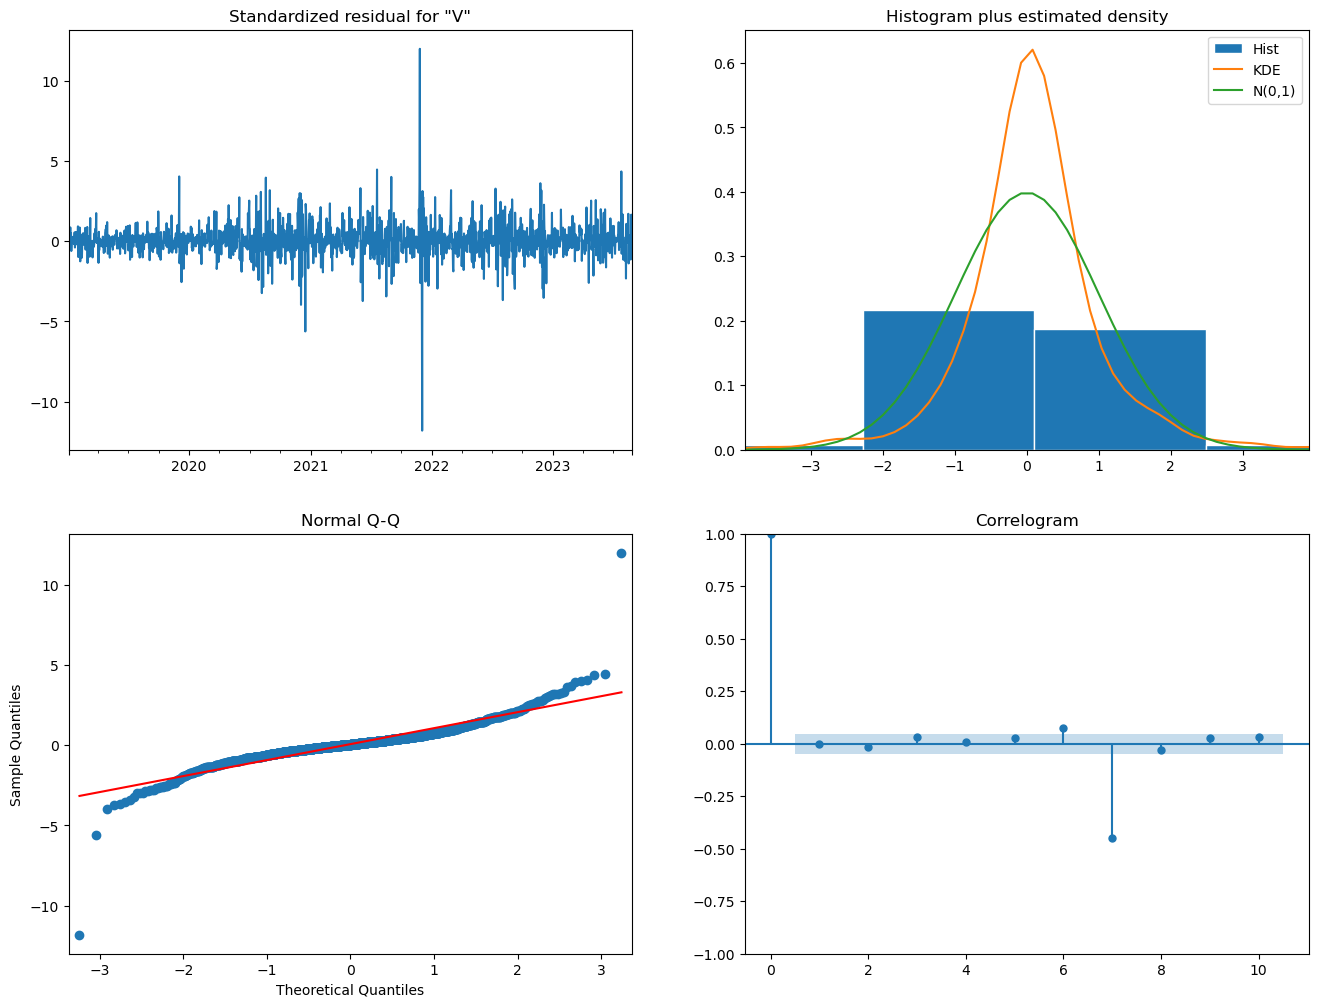

In [80]:

arimax_result.plot_diagnostics(figsize=(16, 12))
plt.show()


In [81]:
# --- Validation predictions ---
y_val_pred_arimax = arimax_result.get_forecast(steps=len(X_val_df), exog=X_val_df).predicted_mean
y_val_pred_arimax_scaled = scaler_y.transform(y_val_pred_arimax.values.reshape(-1, 1))  #  scale predictions
y_val_true_arimax = y_val_df.values  

# --- Test predictions ---
y_test_pred_arimax = arimax_result.get_forecast(steps=len(X_test_df), exog=X_test_df).predicted_mean
y_test_pred_arimax_scaled = scaler_y.transform(y_test_pred_arimax.values.reshape(-1, 1))  #  scale predictions
y_test_true_arimax = y_test_df.values  


In [82]:

# --- Evaluate predictions on scaled data ---
metrics_val_arimax = evaluate_predictions(
    y_val_true_arimax, 
    y_val_pred_arimax.values.reshape(-1, 1), 
    set_name='Validation'
)

metrics_test_arimax = evaluate_predictions(
    y_test_true_arimax, 
    y_test_pred_arimax.values.reshape(-1, 1), 
    set_name='Test'
)


# Extract RMSE, MAE, R² for Validation set
rmse_arimax_val = metrics_val_arimax['RMSE']
mae_arimax_val  = metrics_val_arimax['MAE']
r2_arimax_val   = metrics_val_arimax['R2']

# Extract RMSE, MAE, R² for comparison
rmse_arimax = metrics_test_arimax['RMSE']
mae_arimax  = metrics_test_arimax['MAE']
r2_arimax   = metrics_test_arimax['R2']

Evaluation Metrics for Validation Set:
MAE: 0.1528
RMSE: 0.1704
R2: -24.2112
Evaluation Metrics for Test Set:
MAE: 0.2452
RMSE: 0.3225
R2: -0.1179


In [83]:
# Inverse-transform
y_val_true_arimax = scaler_y.inverse_transform(y_val_df)
y_val_pred_arimax_rescaled = scaler_y.inverse_transform(y_val_pred_arimax.values.reshape(-1,1))


# Inverse-transform
y_test_true_arimax = scaler_y.inverse_transform(y_test_df)
y_test_pred_arimax_rescaled = scaler_y.inverse_transform(y_test_pred_arimax.values.reshape(-1,1))



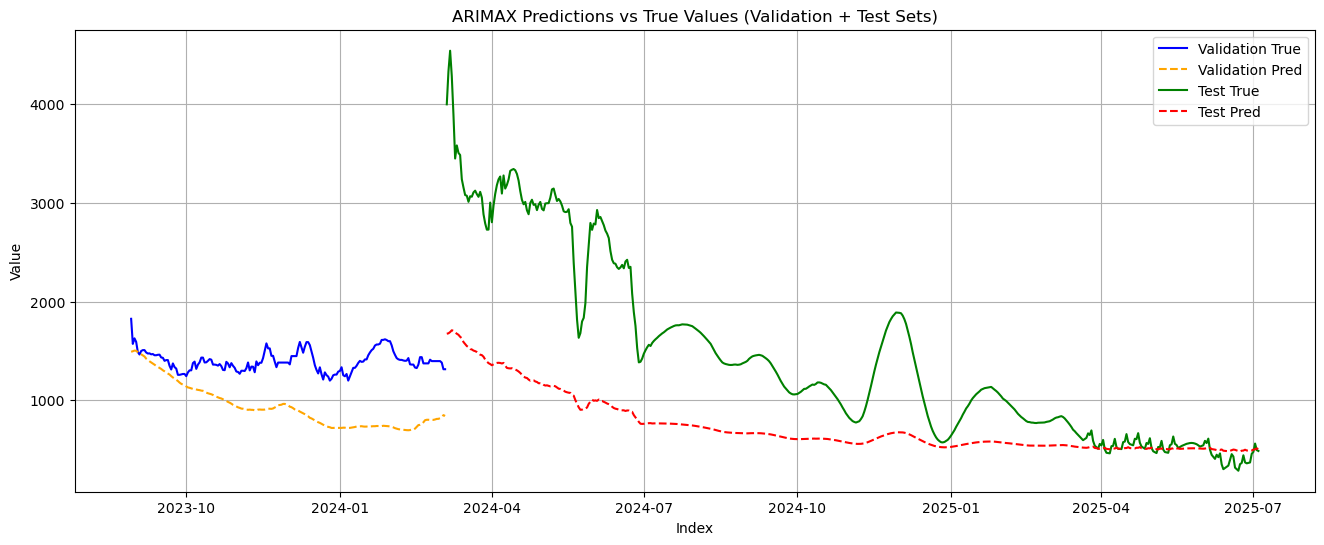

In [84]:
# Validation indices
idx_val_arimax = X_val_df.index
# Test indices
idx_test_arimax = X_test_df.index

# Plot ARIMAX predictions
plot_predictions(
    idx_val_arimax, y_val_true_arimax, y_val_pred_arimax_rescaled,
    idx_test_arimax, y_test_true_arimax, y_test_pred_arimax_rescaled,
    title='ARIMAX Predictions vs True Values (Validation + Test Sets)'
)

In [85]:
def plot_predictions_full(idx_train, y_train, 
                          idx_val, y_val_true, y_val_pred,
                          idx_test, y_test_true, y_test_pred,
                          title='Model Predictions vs True Values'):
    plt.figure(figsize=(18,6))
    
    # --- Training ---
    plt.plot(idx_train, y_train, label='Train True', color='blue')
    
    # --- Validation ---
    plt.plot(idx_val, y_val_true, label='Validation True', color='green')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')
    
    # --- Test ---
    plt.plot(idx_test, y_test_true, label='Test True', color='purple')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')
    
    # Shade validation and test regions
    plt.axvspan(idx_val[0], idx_val[-1], color='green', alpha=0.05)
    plt.axvspan(idx_test[0], idx_test[-1], color='red', alpha=0.05)
    
    plt.xlabel('Index / Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


# LSTM

In [86]:
def build_lstm(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First LSTM layer
        LSTM(64, activation='tanh', return_sequences=True, 
             kernel_regularizer=l2(l2_reg), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(32, kernel_regularizer=l2(l2_reg)),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate model
lstm_model = build_lstm(SEQ_LENGTH, n_features, l2_reg=0.0001)
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop]
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0533 - mae: 0.1637 - val_loss: 0.0106 - val_mae: 0.0473
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - mae: 0.0715 - val_loss: 0.0099 - val_mae: 0.0449
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0134 - mae: 0.0662 - val_loss: 0.0106 - val_mae: 0.0497
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123 - mae: 0.0654 - val_loss: 0.0107 - val_mae: 0.0531
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107 - mae: 0.0622 - val_loss: 0.0100 - val_mae: 0.0527
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.0621 - val_loss: 0.0113 - val_mae: 0.0593
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.0605 - val_loss: 0.0092 - val_mae: 0.0521
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0610 - val_loss: 0.0091 - val_mae: 0.0524
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

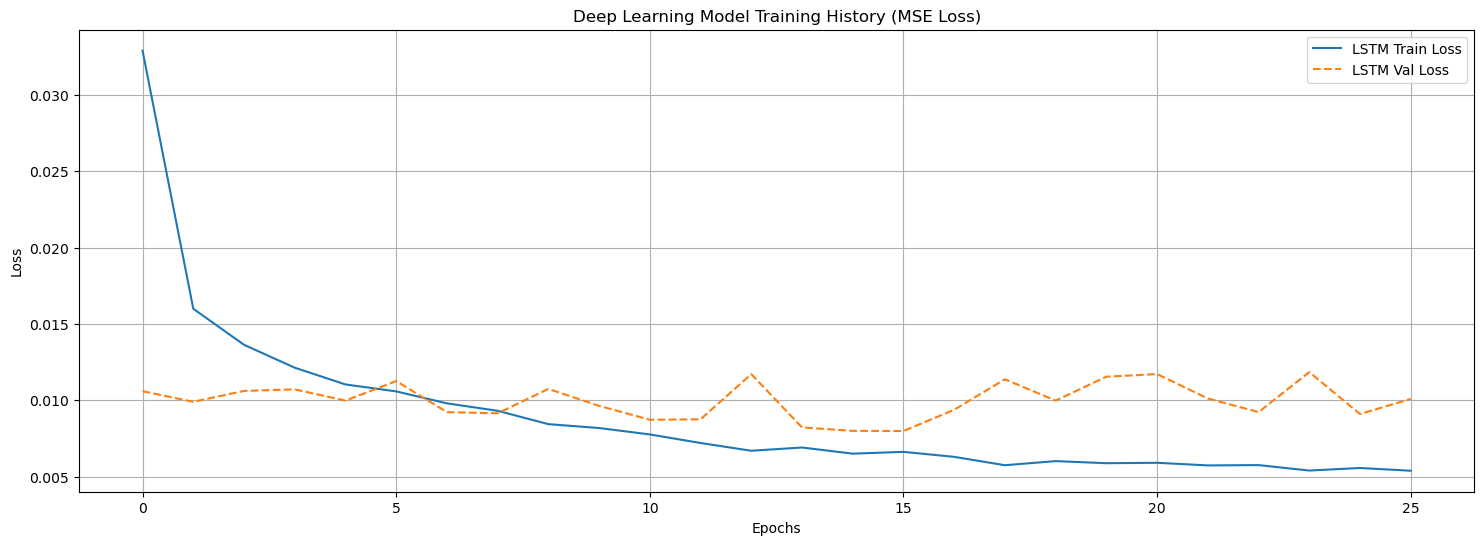

In [88]:
# Call the function
plot_history(
    histories=[history_lstm],
    names=['LSTM']
)

In [89]:
# Validation predictions
y_val_pred = lstm_model.predict(X_val_seq)
# Test predictions
y_test_pred = lstm_model.predict(X_test_seq)

# Validation DataFrame
val_pred_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred.flatten(),
}, index=idx_val_seq)

# Test DataFrame
test_pred_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred.flatten(),
}, index=idx_test_seq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [90]:
y_val_pred_lstm_rescaled = scaler_y.inverse_transform(val_pred_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_df[['y_true']])

y_test_pred_lstm_rescaled = scaler_y.inverse_transform(test_pred_df[['y_pred']])
y_test_true_lstm_rescaled = scaler_y.inverse_transform(test_pred_df[['y_true']])


# --- Evaluate metrics 
metrics_val_lstm  = evaluate_predictions(
    y_true=val_pred_df ['y_true'],
    y_pred=val_pred_df ['y_pred'],
    set_name='Validation'
)

metrics_test_lstm = evaluate_predictions(
    y_true=test_pred_df['y_true'],
    y_pred=test_pred_df['y_pred'],
    set_name='Test'
)


# Extract RMSE, MAE, R² for test set
rmse_lstm = metrics_test_lstm['RMSE']
mae_lstm  = metrics_test_lstm['MAE']
r2_lstm   = metrics_test_lstm['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_lstm_val = metrics_val_lstm['RMSE']
mae_lstm_val  = metrics_val_lstm['MAE']
r2_lstm_val   = metrics_val_lstm['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0485
RMSE: 0.0790
R2: -5.2862
Evaluation Metrics for Test Set:
MAE: 0.0842
RMSE: 0.1404
R2: 0.7634


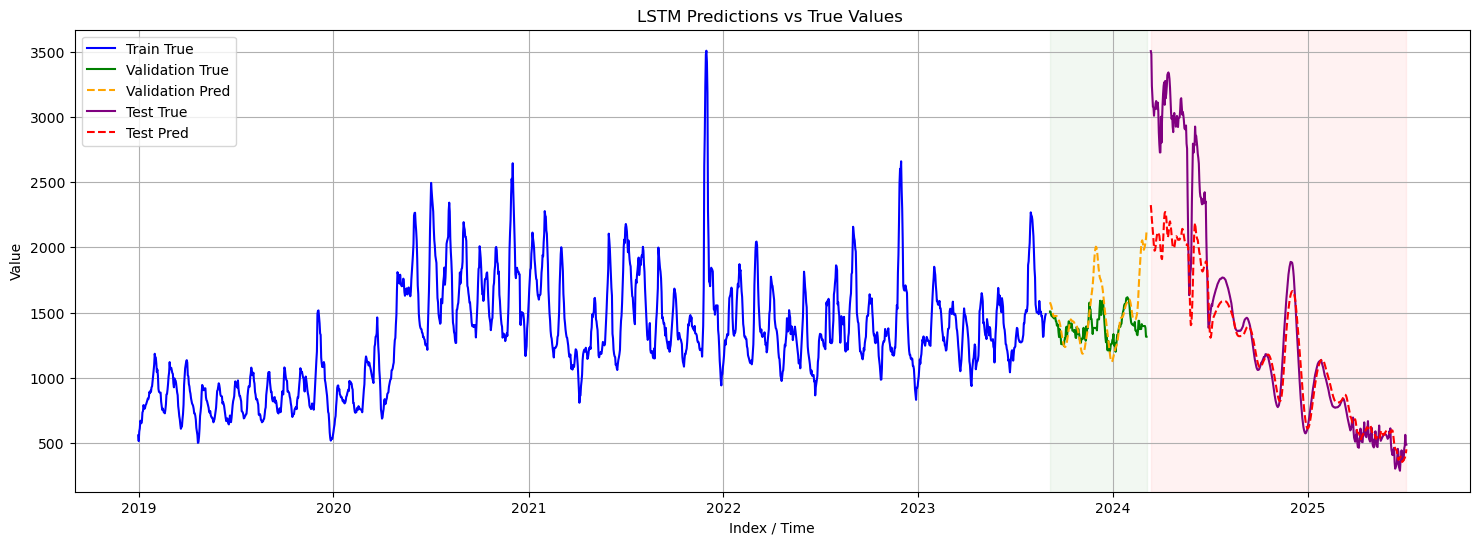

In [92]:
plot_predictions_full(
    idx_train=train.index, y_train=train['Volume_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_lstm_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_lstm_rescaled, y_test_pred=y_test_pred_lstm_rescaled,
    title='LSTM Predictions vs True Values '
)


In [ ]:
rmse_lstm, mae_lstm, r2_lstm = evaluate_model(lstm_model, X_test, y_test)
print(f"LSTM -> RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM -> RMSE: 0.0277, MAE: 0.0225, R2: 0.9877


In [93]:
n_display = 10

# Take first n_display predictions and actuals
actual = y_test_true_lstm_rescaled[:n_display].flatten()
predicted = y_test_pred_lstm_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df)

        date       Actual    Predicted
0 2024-03-12  3503.857143  2323.921143
1 2024-03-13  3481.857143  2274.350098
2 2024-03-14  3236.857143  2211.900879
3 2024-03-15  3153.571429  2165.064697
4 2024-03-16  3077.142857  2113.778076
5 2024-03-17  3070.428571  2054.830566
6 2024-03-18  3008.714286  1998.853760
7 2024-03-19  3065.142857  1974.327148
8 2024-03-20  3060.142857  1977.694458
9 2024-03-21  3104.285714  2005.943115


# Bi-LSTM

In [95]:
def build_bilstm(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First Bi-LSTM layer
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                           kernel_regularizer=l2(l2_reg)),
                      input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second Bi-LSTM layer
        Bidirectional(LSTM(32, kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # single output
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate model
bilstm_model = build_bilstm(SEQ_LENGTH, n_features, l2_reg=0.0001)
bilstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 128)         │        34,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,585 (295.25 KB)

 Trainable params: 75,585 (295.25 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop]
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0538 - mae: 0.1322 - val_loss: 0.0242 - val_mae: 0.0472
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0253 - mae: 0.0630 - val_loss: 0.0218 - val_mae: 0.0549
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186 - mae: 0.0549 - val_loss: 0.0201 - val_mae: 0.0610
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151 - mae: 0.0531 - val_loss: 0.0179 - val_mae: 0.0615
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131 - mae: 0.0532 - val_loss: 0.0150 - val_mae: 0.0565
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118 - mae: 0.0513 - val_loss: 0.0166 - val_mae: 0.0653
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098 - mae: 0.0472 - val_loss: 0.0168 - val_mae: 0.0699
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mae: 0.0486 - val_loss: 0.0152 - val_mae: 0.0674
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0

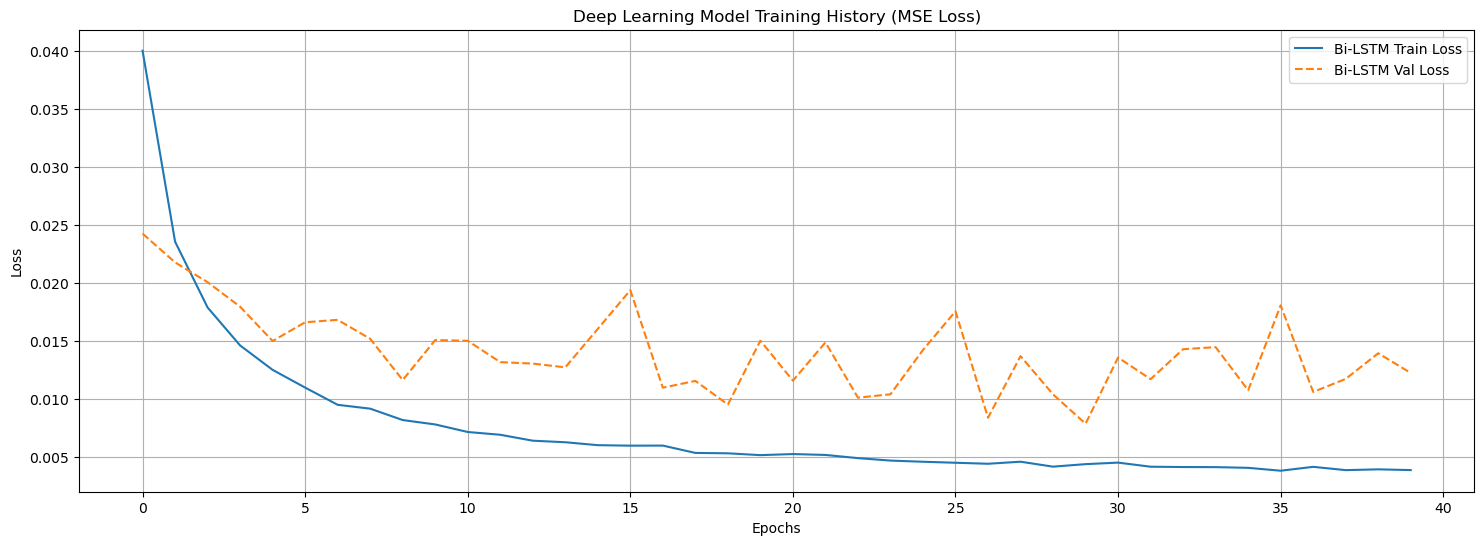

In [97]:
# plot training history
plot_history(
    histories=[history_bilstm],
    names=['Bi-LSTM']
)

In [98]:
# Validation predictions
y_val_pred_bi = bilstm_model.predict(X_val_seq)
# Test predictions
y_test_pred_bi = bilstm_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_bi_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_bi.flatten()
}, index=idx_val_seq)

test_pred_bi_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_bi.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_bi_rescaled = scaler_y.inverse_transform(val_pred_bi_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_bi_df[['y_true']])

y_test_pred_bi_rescaled = scaler_y.inverse_transform(test_pred_bi_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_bi_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [99]:

# --- Evaluate metrics 
metrics_val_bilstm = evaluate_predictions(
    y_true=val_pred_bi_df ['y_true'],
    y_pred=val_pred_bi_df ['y_pred'],
    set_name='Validation'
)

metrics_test_bilstm  = evaluate_predictions(
    y_true=test_pred_bi_df['y_true'],
    y_pred=test_pred_bi_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_bilstm = metrics_test_bilstm['RMSE']
mae_bilstm  = metrics_test_bilstm['MAE']
r2_bilstm   = metrics_test_bilstm['R2']

#Extract RMSE, MAE, R² for Validation set
rmse_bilstm_val = metrics_val_bilstm['RMSE']
mae_bilstm_val  = metrics_val_bilstm['MAE']
r2_bilstm_val   = metrics_val_bilstm['R2']

Evaluation Metrics for Validation Set:
MAE: 0.0506
RMSE: 0.0814
R2: -5.6745
Evaluation Metrics for Test Set:
MAE: 0.0856
RMSE: 0.1472
R2: 0.7399


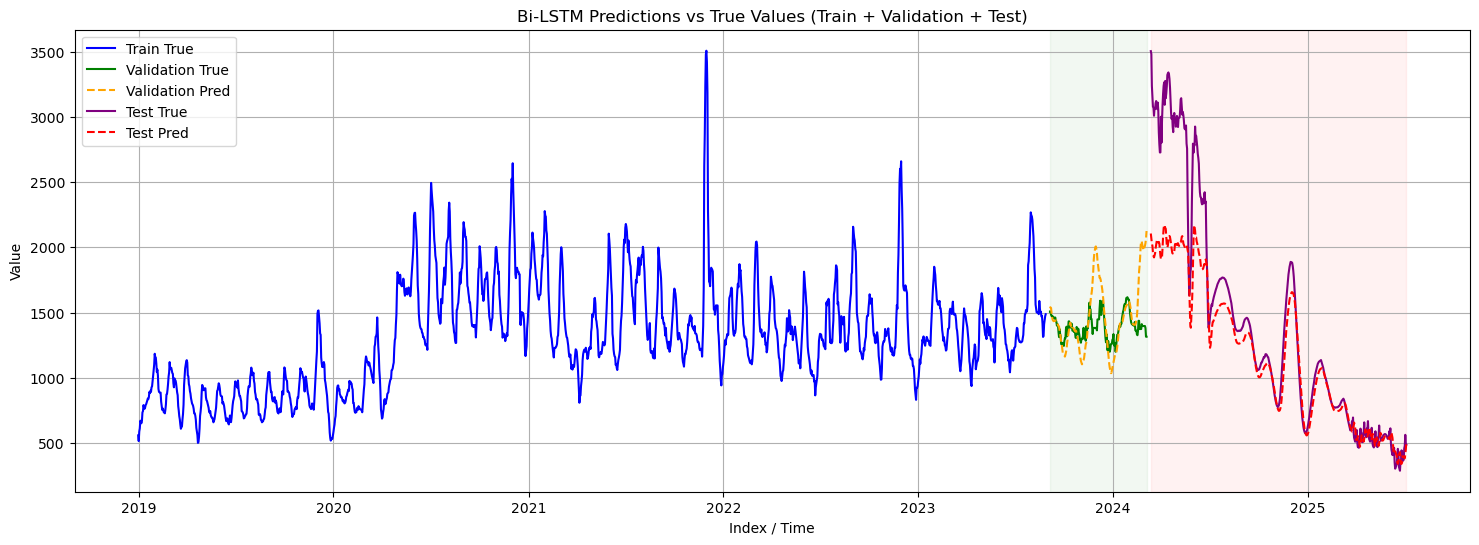

In [101]:
plot_predictions_full(
    idx_train=train.index, y_train=train['Volume_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_bi_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_bi_rescaled,
    title='Bi-LSTM Predictions vs True Values (Train + Validation + Test)'
)


In [102]:
n_display = 10

# Take first n_display predictions and actuals for Bi-LSTM
actual = y_test_true_rescaled[:n_display].flatten()
predicted = y_test_pred_bi_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df_bi = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df_bi)

        date       Actual    Predicted
0 2024-03-12  3503.857143  2105.958740
1 2024-03-13  3481.857143  2069.817139
2 2024-03-14  3236.857143  2030.034180
3 2024-03-15  3153.571429  2011.948975
4 2024-03-16  3077.142857  1960.984497
5 2024-03-17  3070.428571  1934.227905
6 2024-03-18  3008.714286  1922.837646
7 2024-03-19  3065.142857  1939.693237
8 2024-03-20  3060.142857  1953.757935
9 2024-03-21  3104.285714  1992.372559


# GRU

In [103]:
def build_gru(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First GRU layer
        GRU(64, activation='tanh', return_sequences=True,
            kernel_regularizer=l2(l2_reg), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second GRU layer
        GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg)),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate the GRU model
gru_model = build_gru(SEQ_LENGTH, n_features, l2_reg=0.0001)
gru_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 64)          │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,497 (87.88 KB)

 Trainable params: 22,497 (87.88 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0357 - mae: 0.1278 - val_loss: 0.0122 - val_mae: 0.0462
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128 - mae: 0.0629 - val_loss: 0.0160 - val_mae: 0.0631
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - mae: 0.0594 - val_loss: 0.0133 - val_mae: 0.0566
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - mae: 0.0562 - val_loss: 0.0141 - val_mae: 0.0609
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - mae: 0.0573 - val_loss: 0.0134 - val_mae: 0.0595
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mae: 0.0521 - val_loss: 0.0132 - val_mae: 0.0593
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mae: 0.0510 - val_loss: 0.0136 - val_mae: 0.0612
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - mae: 0.0497 - val_loss: 0.0111 - val_mae: 0.0543
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

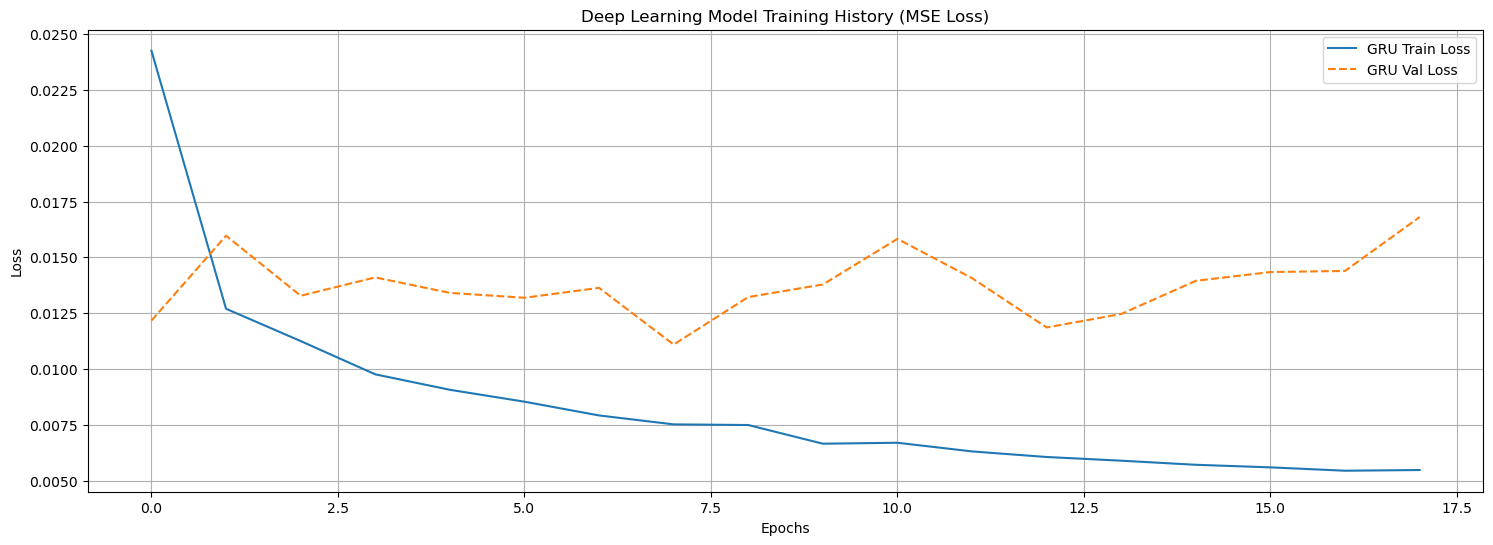

In [105]:
# Call the function
plot_history(
    histories=[history_gru],
    names=[ 'GRU']
)

In [106]:
# Validation predictions
y_val_pred_gru = gru_model.predict(X_val_seq)
# Test predictions
y_test_pred_gru = gru_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_gru_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_gru.flatten()
}, index=idx_val_seq)

test_pred_gru_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_gru.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_gru_rescaled = scaler_y.inverse_transform(val_pred_gru_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_gru_df[['y_true']])

y_test_pred_gru_rescaled = scaler_y.inverse_transform(test_pred_gru_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_gru_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [107]:
# --- Evaluate metrics 
metrics_val_gru = evaluate_predictions(
    y_true=val_pred_gru_df ['y_true'],
    y_pred=val_pred_gru_df ['y_pred'],
    set_name='Validation'
)

metrics_test_gru = evaluate_predictions(
    y_true=test_pred_gru_df['y_true'],
    y_pred=test_pred_gru_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_gru = metrics_test_gru['RMSE']
mae_gru  = metrics_test_gru['MAE']
r2_gru   = metrics_test_gru['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_gru_val = metrics_val_gru['RMSE']
mae_gru_val  = metrics_val_gru['MAE']
r2_gru_val   = metrics_val_gru['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0543
RMSE: 0.0925
R2: -7.6217
Evaluation Metrics for Test Set:
MAE: 0.0711
RMSE: 0.1010
R2: 0.8775


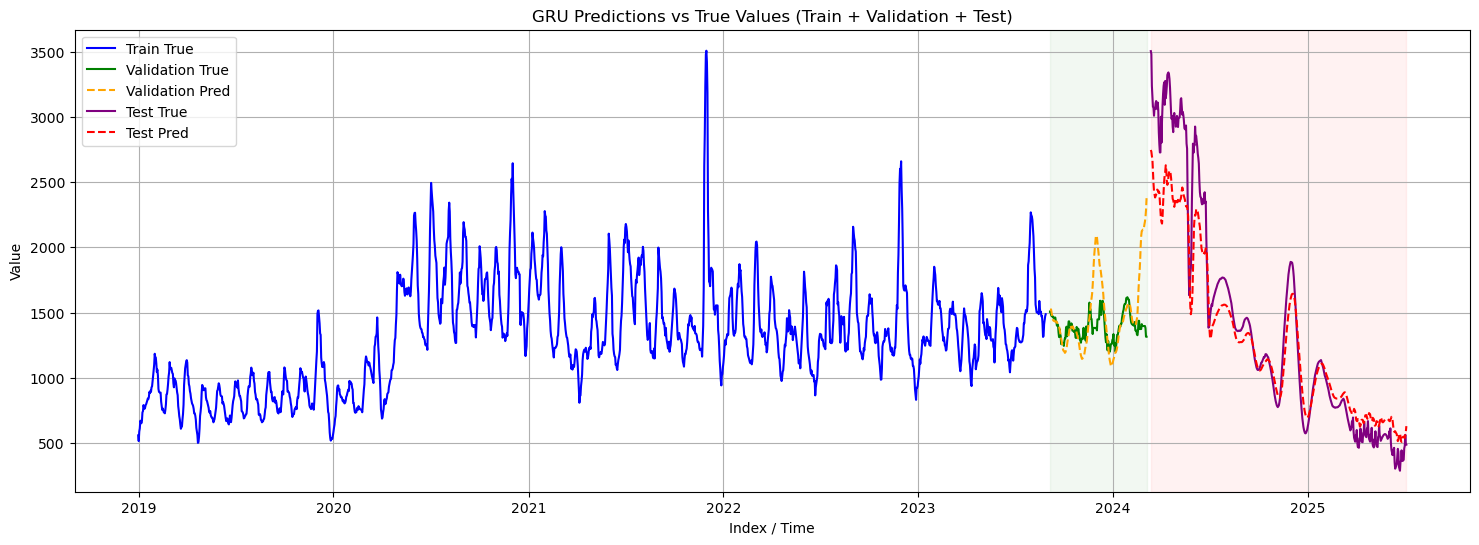

In [109]:
# Plot GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Volume_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_gru_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_gru_rescaled,
    title='GRU Predictions vs True Values (Train + Validation + Test)'
)

In [110]:
n_display = 10

# Take first n_display predictions and actuals for Bi-LSTM
actual = y_test_true_rescaled[:n_display].flatten()
predicted = y_test_pred_gru_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df_gru = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df_gru)

        date       Actual    Predicted
0 2024-03-12  3503.857143  2746.166992
1 2024-03-13  3481.857143  2733.537842
2 2024-03-14  3236.857143  2700.432373
3 2024-03-15  3153.571429  2674.298096
4 2024-03-16  3077.142857  2577.378662
5 2024-03-17  3070.428571  2492.497803
6 2024-03-18  3008.714286  2430.213379
7 2024-03-19  3065.142857  2405.521240
8 2024-03-20  3060.142857  2381.974854
9 2024-03-21  3104.285714  2392.533447


# Bi-GRU

In [124]:
def build_bigru(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First Bi-GRU layer
        Bidirectional(GRU(64, activation='tanh', return_sequences=True,
                          kernel_regularizer=l2(l2_reg)),
                      input_shape=(seq_length, n_features)),
        Dropout(0.2),
        
        # Second Bi-GRU layer
        Bidirectional(GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),
        
        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate the Bi-GRU model
bigru_model = build_bigru(SEQ_LENGTH, n_features, l2_reg=0.0001)
bigru_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 7, 128)         │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,281 (223.75 KB)

 Trainable params: 57,281 (223.75 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
history_bigru = bigru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0513 - mae: 0.1327 - val_loss: 0.0292 - val_mae: 0.0744
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0231 - mae: 0.0622 - val_loss: 0.0238 - val_mae: 0.0645
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0177 - mae: 0.0543 - val_loss: 0.0191 - val_mae: 0.0569
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - mae: 0.0539 - val_loss: 0.0178 - val_mae: 0.0573
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - mae: 0.0479 - val_loss: 0.0191 - val_mae: 0.0659
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mae: 0.0475 - val_loss: 0.0173 - val_mae: 0.0613
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.0463 - val_loss: 0.0149 - val_mae: 0.0552
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mae: 0.0452 - val_loss: 0.0201 - val_mae: 0.0757
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.00

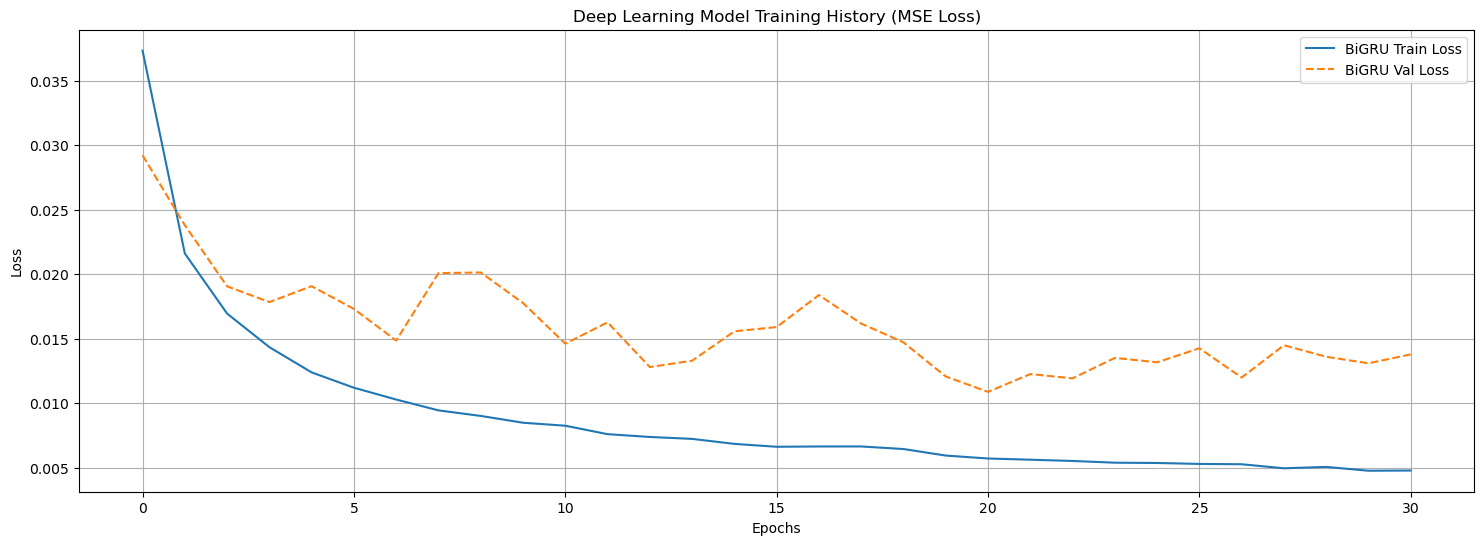

In [126]:
# Call the function
plot_history(
    histories=[history_bigru],
    names=['BiGRU']
)

In [127]:
# Validation predictions
y_val_pred_bigru = bigru_model.predict(X_val_seq)
# Test predictions
y_test_pred_bigru = bigru_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_bigru_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_bigru.flatten()
}, index=idx_val_seq)

test_pred_bigru_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_bigru.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_bigru_rescaled = scaler_y.inverse_transform(val_pred_bigru_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_bigru_df[['y_true']])

y_test_pred_bigru_rescaled = scaler_y.inverse_transform(test_pred_bigru_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_bigru_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [128]:
# --- Evaluate metrics 
metrics_val_bigru = evaluate_predictions(
    y_true=val_pred_bigru_df['y_true'],
    y_pred=val_pred_bigru_df['y_pred'],
    set_name='Validation'
)

metrics_test_bigru = evaluate_predictions(
    y_true=test_pred_bigru_df['y_true'],
    y_pred=test_pred_bigru_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_bigru= metrics_test_bigru['RMSE']
mae_bigru  = metrics_test_bigru['MAE']
r2_bigru  = metrics_test_bigru['R2']


# Extract metrics for Validation set
rmse_bigru_val = metrics_val_bigru['RMSE']
mae_bigru_val  = metrics_val_bigru['MAE']
r2_bigru_val   = metrics_val_bigru['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0547
RMSE: 0.0902
R2: -7.2016
Evaluation Metrics for Test Set:
MAE: 0.0715
RMSE: 0.1232
R2: 0.8180


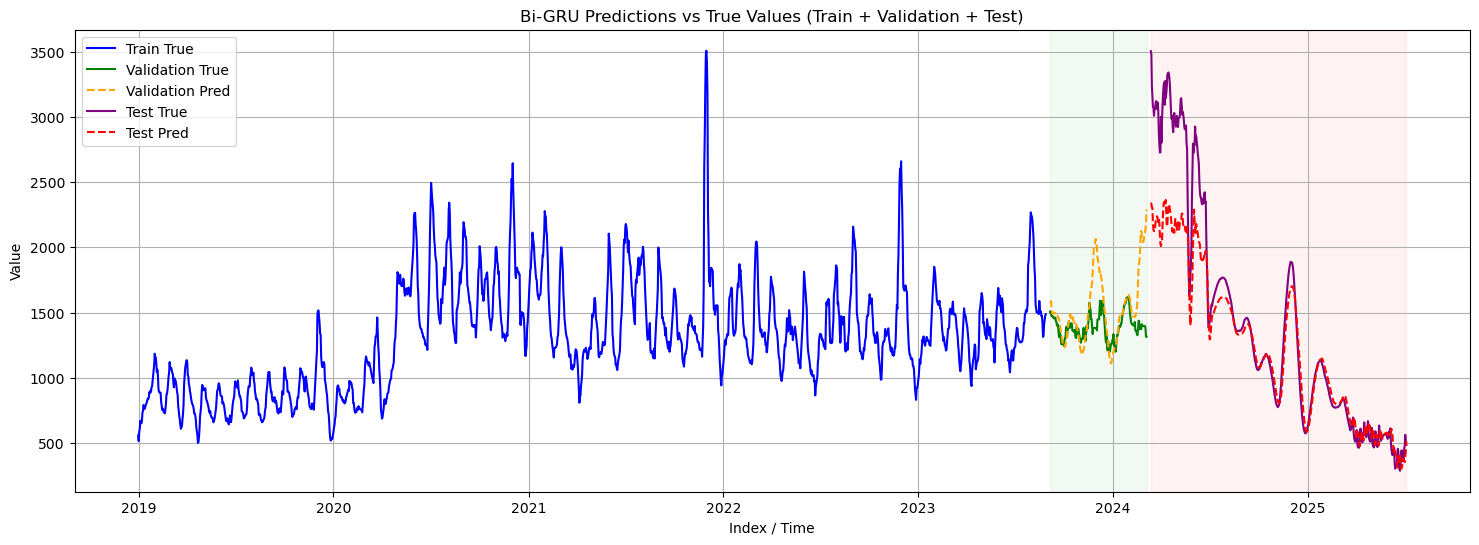

In [130]:
# Plot Bi-GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Volume_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_bigru_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_bigru_rescaled,
    title='Bi-GRU Predictions vs True Values (Train + Validation + Test)'
)

# Hybrid model

In [116]:
def build_bilstm_bigru_hybrid(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # 1st Bi-LSTM layer
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                           kernel_regularizer=l2(l2_reg)), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # 2nd Bi-LSTM layer
        Bidirectional(LSTM(32, activation='tanh', return_sequences=True,
                           kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # 1st Bi-GRU layer
        Bidirectional(GRU(64, activation='tanh', return_sequences=True,
                          kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # 2nd Bi-GRU layer
        Bidirectional(GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Instantiate 4-layer hybrid model
hybrid_model = build_bilstm_bigru_hybrid(SEQ_LENGTH, n_features, l2_reg=0.0001)
hybrid_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 7, 128)         │        34,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 7, 64)          │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 7, 128)         │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,609 (611.75 KB)

 Trainable params: 156,609 (611.75 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
history_hybrid= hybrid_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0885 - mae: 0.1224 - val_loss: 0.0521 - val_mae: 0.0439
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0526 - mae: 0.0663 - val_loss: 0.0427 - val_mae: 0.0577
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0379 - mae: 0.0572 - val_loss: 0.0369 - val_mae: 0.0676
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0299 - mae: 0.0555 - val_loss: 0.0296 - val_mae: 0.0613
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0233 - mae: 0.0489 - val_loss: 0.0238 - val_mae: 0.0532
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0201 - mae: 0.0472 - val_loss: 0.0223 - val_mae: 0.0566
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0171 - mae: 0.0447 - val_loss: 0.0199 - val_mae: 0.0542
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0157 - mae: 0.0444 - val_loss: 0.0205 - val_mae: 0.0632
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - l

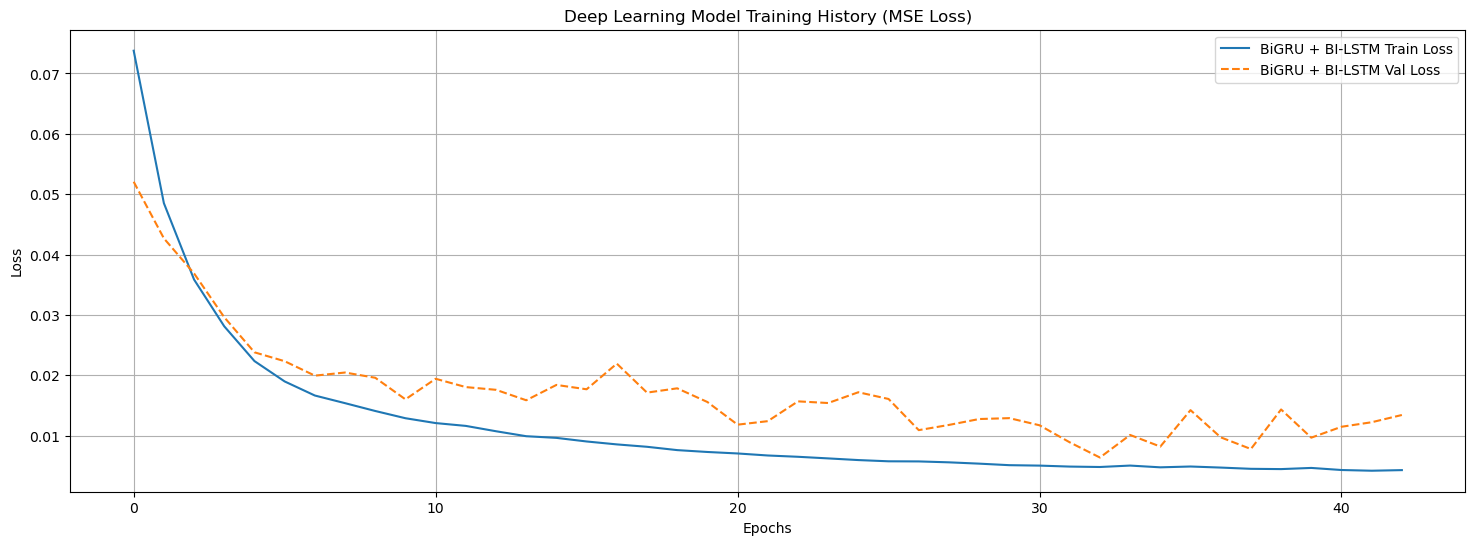

In [118]:
# Call the function
plot_history(
    histories=[history_hybrid],
    names=['BiGRU + BI-LSTM']
)

In [119]:
# --- Predictions ---
# Validation
y_val_pred_hybrid = hybrid_model.predict(X_val_seq, verbose=0)
# Test
y_test_pred_hybrid = hybrid_model.predict(X_test_seq, verbose=0)

# --- Map predictions to DataFrames using original indices ---
val_pred_hybrid_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_hybrid.flatten()
}, index=idx_val_seq)

test_pred_hybrid_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_hybrid.flatten()
}, index=idx_test_seq)

# --- Inverse scaling if target was scaled ---
y_val_pred_hybrid_rescaled = scaler_y.inverse_transform(val_pred_hybrid_df[['y_pred']])
y_val_true_hybrid_rescaled = scaler_y.inverse_transform(val_pred_hybrid_df[['y_true']])

y_test_pred_hybrid_rescaled = scaler_y.inverse_transform(test_pred_hybrid_df[['y_pred']])
y_test_true_hybrid_rescaled = scaler_y.inverse_transform(test_pred_hybrid_df[['y_true']])


In [120]:

# --- Evaluate metrics 
metrics_val_hybrid = evaluate_predictions(
    y_true=val_pred_hybrid_df['y_true'],
    y_pred=val_pred_hybrid_df['y_pred'],
    set_name='Validation'
)

metrics_test_hybrid = evaluate_predictions(
    y_true=test_pred_hybrid_df['y_true'],
    y_pred=test_pred_hybrid_df['y_pred'],
    set_name='Test'
)

# --- Extract metrics for Test set ---
rmse_hybrid = metrics_test_hybrid['RMSE']
mae_hybrid  = metrics_test_hybrid['MAE']
r2_hybrid   = metrics_test_hybrid['R2']

# --- Extract metrics for Validation set ---
rmse_hybrid_val = metrics_val_hybrid['RMSE']
mae_hybrid_val  = metrics_val_hybrid['MAE']
r2_hybrid_val   = metrics_val_hybrid['R2']



Evaluation Metrics for Validation Set:
MAE: 0.0431
RMSE: 0.0682
R2: -3.6863
Evaluation Metrics for Test Set:
MAE: 0.1058
RMSE: 0.1651
R2: 0.6729


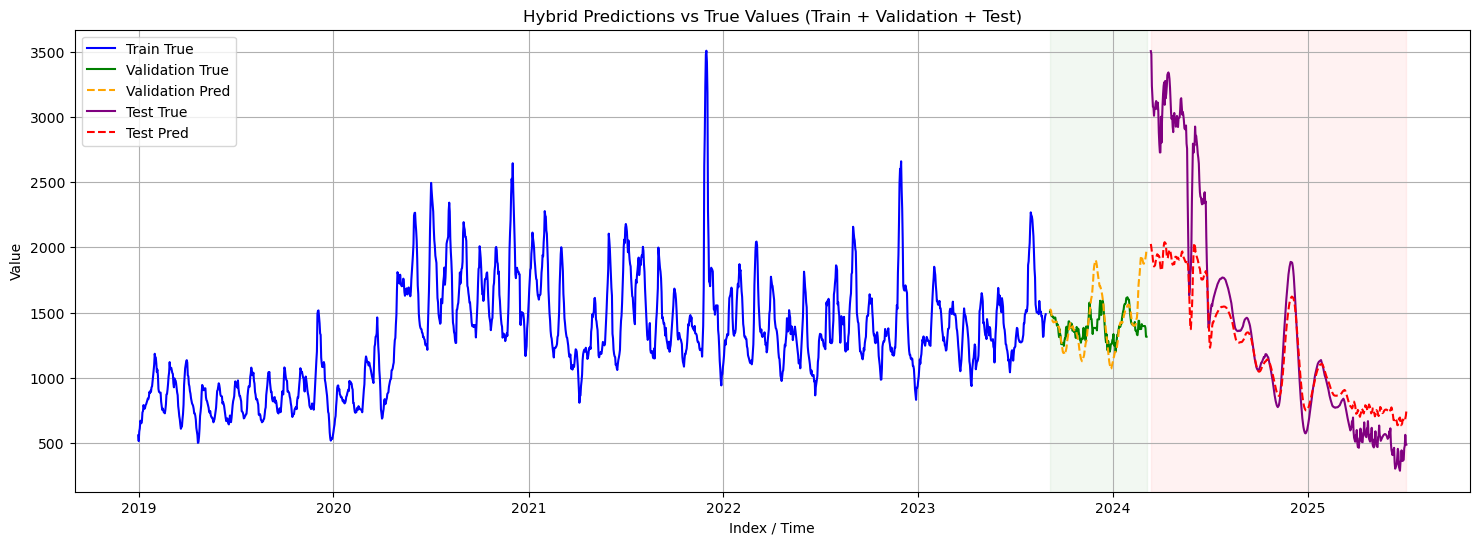

In [122]:
# Plot Bi-GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Volume_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_hybrid_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_hybrid_rescaled,
    title='Hybrid Predictions vs True Values (Train + Validation + Test)'
)

# RESULTS

In [131]:
# --- Plot actual values ---
fig = go.Figure()

# Actual series
fig.add_trace(go.Scatter(x=train.index, y=scaler_y.inverse_transform(y_train_df).flatten(),
                         mode='lines', name='Train Actual', line=dict(color='black')))
fig.add_trace(go.Scatter(x=val.index, y=scaler_y.inverse_transform(y_val_df).flatten(),
                         mode='lines', name='Val Actual', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=test.index, y=scaler_y.inverse_transform(y_test_df).flatten(),
                         mode='lines', name='Test Actual', line=dict(color='darkgray')))

# --- Validation predictions (lighter, same color as test) ---
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_lstm_rescaled.flatten(),
                         mode='lines', name='LSTM Val Pred', line=dict(color='rgba(0,0,255,0.4)')))       # blue
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_bi_rescaled.flatten(),
                         mode='lines', name='Bi-LSTM Val Pred', line=dict(color='rgba(255,165,0,0.4)')))  # orange
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_gru_rescaled.flatten(),
                         mode='lines', name='GRU Val Pred', line=dict(color='rgba(0,128,0,0.4)')))       # green
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_bigru_rescaled.flatten(),
                         mode='lines', name='Bi-GRU Val Pred', line=dict(color='rgba(128,0,128,0.4)')))   # purple
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_hybrid_rescaled.flatten(),
                         mode='lines', name='Hybrid Val Pred', line=dict(color='rgba(165,42,42,0.4)')))   # brown
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_arimax_rescaled.flatten(),
                         mode='lines', name='SARIMAX Val Pred', line=dict(color='rgba(255,0,0,0.4)')))     # red

# --- Test predictions (solid, same color) ---
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_lstm_rescaled.flatten(),
                         mode='lines', name='LSTM Test Pred', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_bi_rescaled.flatten(),
                         mode='lines', name='Bi-LSTM Test Pred', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_gru_rescaled.flatten(),
                         mode='lines', name='GRU Test Pred', line=dict(color='green')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_bigru_rescaled.flatten(),
                         mode='lines', name='Bi-GRU Test Pred', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_hybrid_rescaled.flatten(),
                         mode='lines', name='Hybrid Test Pred', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_arimax_rescaled.flatten(),
                         mode='lines', name='SARIMAX Test Pred', line=dict(color='red')))

# --- Layout ---
fig.update_layout(
    title='Train, Validation, and Test Predictions: SARIMAX & DL Models',
    xaxis_title='Index',
    yaxis_title='Value',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


In [132]:
# --- Metrics for Validation set ---
metrics_val_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU', 'Hybrid'],
    'Dataset': 'Validation',
    'RMSE': [rmse_arimax_val, rmse_lstm_val, rmse_bilstm_val, rmse_gru_val, rmse_bigru_val, rmse_hybrid_val],
    'MAE':  [mae_arimax_val, mae_lstm_val, mae_bilstm_val, mae_gru_val, mae_bigru_val, mae_hybrid_val],
    'R²':   [r2_arimax_val, r2_lstm_val, r2_bilstm_val, r2_gru_val, r2_bigru_val, r2_hybrid_val]
})

# Display
metrics_val_df

Model     Dataset      RMSE       MAE         R²
0   ARIMAX  Validation  0.170366  0.152845 -24.211223
1     LSTM  Validation  0.078968  0.048470  -5.286157
2  Bi-LSTM  Validation  0.081370  0.050635  -5.674514
3      GRU  Validation  0.092481  0.054306  -7.621675
4   Bi-GRU  Validation  0.090200  0.054730  -7.201640
5   Hybrid  Validation  0.068182  0.043064  -3.686277

In [133]:
# --- Metrics for Testing set ---
metrics_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU', 'Hybrid'],
    'Dataset': 'Test',
    'RMSE': [rmse_arimax, rmse_lstm, rmse_bilstm, rmse_gru, rmse_bigru, rmse_hybrid],
    'MAE':  [mae_arimax, mae_lstm, mae_bilstm, mae_gru, mae_bigru, mae_hybrid],
    'R²':   [r2_arimax, r2_lstm, r2_bilstm, r2_gru, r2_bigru, r2_hybrid]
})

metrics_df

Model Dataset      RMSE       MAE        R²
0   ARIMAX    Test  0.322505  0.245177 -0.117914
1     LSTM    Test  0.140401  0.084200  0.763435
2  Bi-LSTM    Test  0.147216  0.085624  0.739912
3      GRU    Test  0.101035  0.071055  0.877493
4   Bi-GRU    Test  0.123157  0.071536  0.817974
5   Hybrid    Test  0.165088  0.105776  0.672928

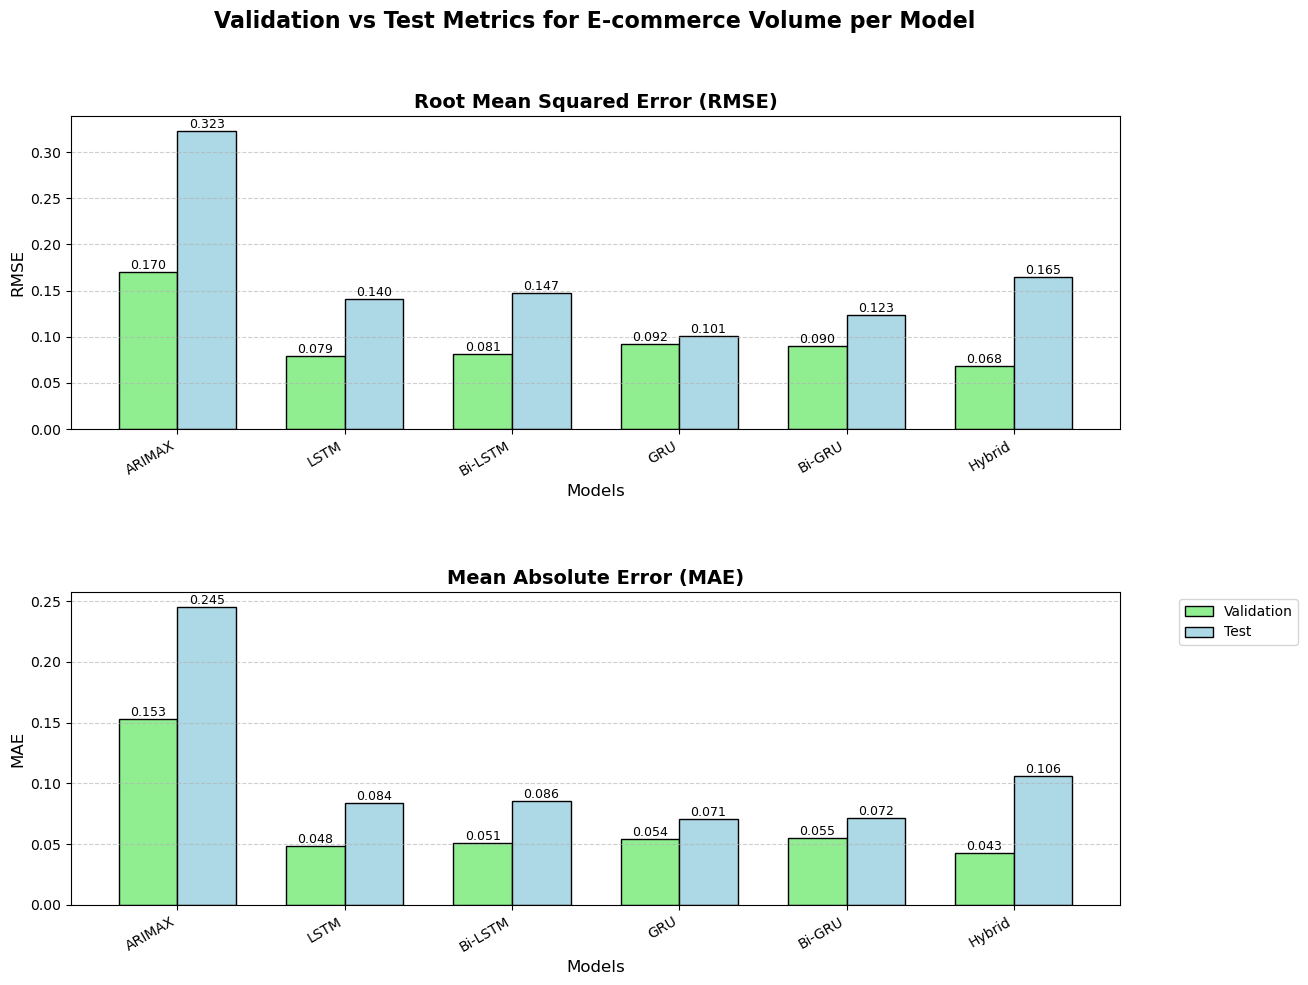

In [134]:
def plot_metrics(metrics_val_df, metrics_test_df):
    models = metrics_val_df['Model']
    metrics_names = ['RMSE', 'MAE']  # remove R²
    titles = ['Root Mean Squared Error (RMSE)', 
              'Mean Absolute Error (MAE)']
    
    width = 0.35
    x = np.arange(len(models))
    
    plt.figure(figsize=(12, 10))  # slightly shorter since only 2 plots
    plt.suptitle('Validation vs Test Metrics for E-commerce Volume per Model', fontsize=16, weight='bold')
    
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 1, i + 1)
        
        val_values = metrics_val_df[metric]
        test_values = metrics_test_df[metric]
        
        bars_val = plt.bar(x - width/2, val_values, width, label='Validation', color='lightgreen', edgecolor='black')
        bars_test = plt.bar(x + width/2, test_values, width, label='Test', color='lightblue', edgecolor='black')
        
        # Annotate bars
        for bar in bars_val + bars_test:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.title(titles[i], fontsize=14, weight='bold')
        plt.xlabel('Models', fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.xticks(x, models, rotation=30, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.tight_layout(rect=[0, 0, 0.95, 0.95], h_pad=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the function
plot_metrics(metrics_val_df, metrics_df)


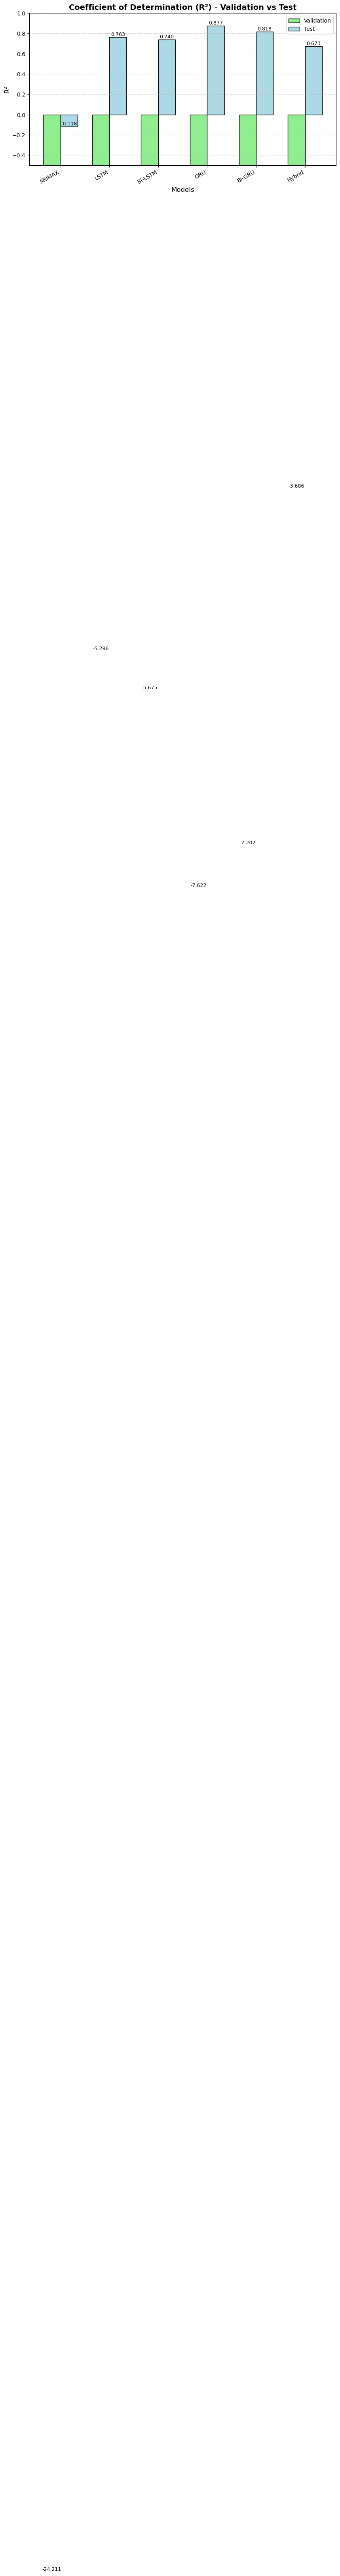

In [135]:
# Models and R² values
models = metrics_val_df['Model']
x = np.arange(len(models))
width = 0.35

# Extract R²
r2_val = metrics_val_df['R²'].astype(float)   # ensure numeric
r2_test = metrics_df['R²'].astype(float)      # ensure numeric

plt.figure(figsize=(10, 5))

# Plot Validation and Test bars
bars_val = plt.bar(x - width/2, r2_val, width, label='Validation', color='lightgreen', edgecolor='black')
bars_test = plt.bar(x + width/2, r2_test, width, label='Test', color='lightblue', edgecolor='black')

# Annotate bars
for bar in bars_val + bars_test:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Titles and labels
plt.title('Coefficient of Determination (R²) - Validation vs Test', fontsize=14, weight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.xticks(x, models, rotation=30, ha='right')
plt.ylim(-0.5, 1)  # accommodate negative R² values
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# walk-forward validation

In [136]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

def walk_forward_sarimax(order, y_train_df, X_train_df, y_val_df, X_val_df, y_test_df, X_test_df):
    """
    Walk-forward validation for SARIMAX.
    """
    # --- Fit model on training set ---
    model = SARIMAX(
        endog=y_train_df,
        exog=X_train_df,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    result = model.fit(method="powell", disp=False)
    
    # --- Forecast validation set ---
    val_forecast = result.get_forecast(steps=len(y_val_df), exog=X_val_df)
    y_val_pred = val_forecast.predicted_mean.values
    
    # --- Forecast test set ---
    full_model = SARIMAX(
        endog=pd.concat([y_train_df, y_val_df]),
        exog=pd.concat([X_train_df, X_val_df]),
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    full_result = full_model.fit(method="powell", disp=False)
    
    test_forecast = full_result.get_forecast(steps=len(y_test_df), exog=X_test_df)
    y_test_pred = test_forecast.predicted_mean.values
    
    # --- Wrap into DataFrames with indices ---
    val_preds_df = pd.DataFrame({
        "y_true": y_val_df.values.flatten(),
        "y_pred": y_val_pred.flatten()
    }, index=y_val_df.index)

    test_preds_df = pd.DataFrame({
        "y_true": y_test_df.values.flatten(),
        "y_pred": y_test_pred.flatten()
    }, index=y_test_df.index)
    
    return val_preds_df, test_preds_df, result


# Sarimax + Validation

In [137]:
# Choose SARIMAX order
sarimax_order = (2,0,1)

# Run walk-forward
val_preds_sarimax, test_preds_sarimax, sarimax_model = walk_forward_sarimax(
    order=sarimax_order,
    y_train_df=y_train_df, X_train_df=X_train_df,
    y_val_df=y_val_df, X_val_df=X_val_df,
    y_test_df=y_test_df, X_test_df=X_test_df
)

# --- Evaluate ---
metrics_val_sarimax = evaluate_predictions(val_preds_sarimax["y_true"], val_preds_sarimax["y_pred"], set_name="Validation")
metrics_test_sarimax = evaluate_predictions(test_preds_sarimax["y_true"], test_preds_sarimax["y_pred"], set_name="Test")

# Extract metrics
rmse_sarimax_val, mae_sarimax_val, r2_sarimax_val = metrics_val_sarimax.values()
rmse_sarimax, mae_sarimax, r2_sarimax = metrics_test_sarimax.values()


Evaluation Metrics for Validation Set:
MAE: 0.0506
RMSE: 0.0650
R2: -2.6651
Evaluation Metrics for Test Set:
MAE: 0.2209
RMSE: 0.3046
R2: 0.0028


In [138]:
def walk_forward_corrected(model_fn, 
                          X_train_seq, y_train_seq, 
                          X_val_seq, y_val_seq, 
                          X_test_seq, y_test_seq,
                          seq_length, 
                          epochs=50, batch_size=32, 
                          verbose=0, retrain_frequency=5):
    """
    Corrected walk-forward validation with proper time series handling.
    
    Args:
        retrain_frequency: How often to retrain model (reduces overfitting)
    """
    
    n_features = X_train_seq.shape[2]
    
    # Initialize model once
    model = model_fn(seq_length, n_features)
    
    # Early stopping for initial training only
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=verbose
    )
    
    # --- Initial Training ---
    print("Initial training on base dataset...")
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),  # Use explicit validation
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        callbacks=[early_stop],
        shuffle=False  # CRITICAL: No shuffling for time series
    )
    
    # --- Walk-forward Validation ---
    val_preds = []
    train_X_current = X_train_seq.copy()
    train_y_current = y_train_seq.copy()
    
    for i in range(len(X_val_seq)):
        if verbose > 0:
            print(f"Validation step {i+1}/{len(X_val_seq)}")
        
        # Predict before expanding training set
        y_pred = model.predict(X_val_seq[i:i+1], verbose=0)[0, 0]
        val_preds.append(y_pred)
        
        # Only retrain periodically to prevent overfitting
        if (i % retrain_frequency == 0) or (i == len(X_val_seq) - 1):
            if verbose > 0:
                print(f"Retraining model at step {i}...")
            
            # Expand training window
            train_X_current = np.vstack([train_X_current, X_val_seq[:i+1]])
            train_y_current = np.vstack([train_y_current, y_val_seq[:i+1]])
            
            # Retrain with very few epochs to adapt gradually
            model.fit(
                train_X_current, train_y_current,
                epochs=3,  # Few epochs to prevent overfitting
                batch_size=batch_size,
                verbose=0,
                shuffle=False
            )
    
    val_preds = np.array(val_preds)
    
    # --- Walk-forward Test ---
    test_preds = []
    
    # Include validation data in final training
    train_X_final = np.vstack([X_train_seq, X_val_seq])
    train_y_final = np.vstack([y_train_seq, y_val_seq])
    
    # Final training before test
    model.fit(
        train_X_final, train_y_final,
        epochs=10,  # Final tuning
        batch_size=batch_size,
        verbose=verbose,
        shuffle=False
    )
    
    # Test walk-forward (usually you wouldn't retrain during test in real scenarios)
    for i in range(len(X_test_seq)):
        y_pred = model.predict(X_test_seq[i:i+1], verbose=0)[0, 0]
        test_preds.append(y_pred)
        
        # In real testing, you typically don't retrain on test data
        # This maintains the integrity of your test set evaluation
    
    test_preds = np.array(test_preds)
    
    # Calculate metrics
    val_metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_val_seq, val_preds)),
        "MAE": mean_absolute_error(y_val_seq, val_preds),
        "R2": r2_score(y_val_seq, val_preds),
        "MAPE": np.mean(np.abs((y_val_seq - val_preds) / y_val_seq)) * 100
    }
    
    test_metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_test_seq, test_preds)),
        "MAE": mean_absolute_error(y_test_seq, test_preds),
        "R2": r2_score(y_test_seq, test_preds),
        "MAPE": np.mean(np.abs((y_test_seq - test_preds) / y_test_seq)) * 100
    }
    
    return {
        "Validation": {"metrics": val_metrics, "preds": val_preds},
        "Test": {"metrics": test_metrics, "preds": test_preds},
        "model": model,
        "final_train_size": train_X_final.shape[0]
    }

In [139]:
def walk_forward_named(model_name, model_fn,
                       X_train_seq, y_train_seq,
                       X_val_seq, y_val_seq,
                       X_test_seq, y_test_seq,
                       seq_length,
                       epochs=50, batch_size=32,
                       retrain_frequency=5, verbose=0):
    """
    Walk-forward validation + test with automatic named metrics.

    Returns:
        metrics_df: DataFrame with Validation & Test metrics
        val_preds: array of validation predictions
        test_preds: array of test predictions
        trained_model: final trained model
        metrics_named: dict with named metrics (e.g., rmse_lstm_val)
    """
    results = walk_forward_corrected(
        model_fn=model_fn,
        X_train_seq=X_train_seq, y_train_seq=y_train_seq,
        X_val_seq=X_val_seq, y_val_seq=y_val_seq,
        X_test_seq=X_test_seq, y_test_seq=y_test_seq,
        seq_length=seq_length,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )

    val_metrics = results["Validation"]["metrics"]
    test_metrics = results["Test"]["metrics"]
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame([
        {
            "Model": model_name,
            "Dataset": "Validation",
            "RMSE": val_metrics["RMSE"],
            "MAE": val_metrics["MAE"],
            "R2": val_metrics["R2"],
            "MAPE": val_metrics.get("MAPE", np.nan)
        },
        {
            "Model": model_name,
            "Dataset": "Test",
            "RMSE": test_metrics["RMSE"],
            "MAE": test_metrics["MAE"],
            "R2": test_metrics["R2"],
            "MAPE": test_metrics.get("MAPE", np.nan)
        }
    ])

    # Create named metrics for easy access
    prefix = model_name.lower().replace("-", "_")
    metrics_named = {
        f"rmse_{prefix}_val": val_metrics["RMSE"],
        f"mae_{prefix}_val": val_metrics["MAE"],
        f"r2_{prefix}_val": val_metrics["R2"],
        f"rmse_{prefix}_test": test_metrics["RMSE"],
        f"mae_{prefix}_test": test_metrics["MAE"],
        f"r2_{prefix}_test": test_metrics["R2"]
    }
    
    return metrics_df, results["Validation"]["preds"], results["Test"]["preds"], results["model"], metrics_named


# a. LSTM + Validation

In [140]:
metrics_df_lstm, val_preds_lstm, test_preds_lstm, model_lstm, metrics_named_lstm = walk_forward_named(
    model_name="LSTM",
    model_fn=build_lstm,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_lstm)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0205 - mae: 0.0882 - val_loss: 0.0098 - val_mae: 0.0456
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156 - mae: 0.0708 - val_loss: 0.0104 - val_mae: 0.0462
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151 - mae: 0.0757 - val_loss: 0.0128 - val_mae: 0.0617
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - mae: 0.0744 - val_loss: 0.0133 - val_mae: 0.0661
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - mae: 0.0679 - val_loss: 0.0118 - val_mae: 0.0605
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.0633 - val_loss: 0.0115 - val_mae: 0.0606
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation step 1/182
Retraining model at step 0...
Validation step 2/182
Validation step 3/182
Validation step 4/182
Validation step 5/182
Validation step 6/182
Retraining model

In [142]:
# --- Extract LSTM metrics from metrics_named_lstm ---
rmse_lstm_val = metrics_named_lstm['rmse_lstm_val']
mae_lstm_val  = metrics_named_lstm['mae_lstm_val']
r2_lstm_val   = metrics_named_lstm['r2_lstm_val']

rmse_lstm     = metrics_named_lstm['rmse_lstm_test']
mae_lstm      = metrics_named_lstm['mae_lstm_test']
r2_lstm       = metrics_named_lstm['r2_lstm_test']

# print metrics
print(f"Validation - RMSE: {rmse_lstm_val:.4f}, MAE: {mae_lstm_val:.4f}, R2: {r2_lstm_val:.4f}")
print(f"Test       - RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")


Validation - RMSE: 0.0547, MAE: 0.0394, R2: -2.0119
Test       - RMSE: 0.1733, MAE: 0.1005, R2: 0.6398


# Bi-LSTM + validation

In [143]:
metrics_df_bilstm, val_preds_bilstm, test_preds_bilstm, model_bilstm, metrics_named_bilstm = walk_forward_named(
    model_name="BI-LSTM",
    model_fn=build_bilstm,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_bilstm)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0321 - mae: 0.0663 - val_loss: 0.0225 - val_mae: 0.0416
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - mae: 0.0702 - val_loss: 0.0178 - val_mae: 0.0530
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - mae: 0.0487 - val_loss: 0.0152 - val_mae: 0.0507
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - mae: 0.0498 - val_loss: 0.0131 - val_mae: 0.0514
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - mae: 0.0468 - val_loss: 0.0116 - val_mae: 0.0512
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mae: 0.0449 - val_loss: 0.0112 - val_mae: 0.0506
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0442 - val_loss: 0.0108 - val_mae: 0.0508
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0412 - val_loss: 0.0108 - val_mae: 0.0514
Epoch 9/100
27/27 ━━━━━━━━━

In [144]:
# --- Extract Bi-LSTM metrics from metrics_named_bilstm ---
rmse_bi_lstm_val = metrics_named_bilstm['rmse_bi_lstm_val']
mae_bi_lstm_val  = metrics_named_bilstm['mae_bi_lstm_val']
r2_bi_lstm_val   = metrics_named_bilstm['r2_bi_lstm_val']

rmse_bi_lstm    = metrics_named_bilstm['rmse_bi_lstm_test']
mae_bi_lstm      = metrics_named_bilstm['mae_bi_lstm_test']
r2_bi_lstm       = metrics_named_bilstm['r2_bi_lstm_test']

# print metrics
print(f"Validation - RMSE: {rmse_bi_lstm_val:.4f}, MAE: {mae_bi_lstm_val:.4f}, R2: {r2_bi_lstm_val:.4f}")
print(f"Test       - RMSE: {rmse_bi_lstm:.4f}, MAE: {mae_bi_lstm:.4f}, R2: {r2_bi_lstm:.4f}")


Validation - RMSE: 0.0552, MAE: 0.0390, R2: -2.0741
Test       - RMSE: 0.1686, MAE: 0.1040, R2: 0.6590


# GRU + Validation

In [145]:
metrics_df_gru, val_preds_gru, test_preds_gru, model_gru, metrics_named_gru = walk_forward_named(
    model_name="gru",
    model_fn=build_gru,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_gru)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0160 - mae: 0.0689 - val_loss: 0.0113 - val_mae: 0.0425
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - mae: 0.0700 - val_loss: 0.0115 - val_mae: 0.0598
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - mae: 0.0473 - val_loss: 0.0105 - val_mae: 0.0525
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - mae: 0.0495 - val_loss: 0.0101 - val_mae: 0.0537
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - mae: 0.0477 - val_loss: 0.0097 - val_mae: 0.0541
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mae: 0.0465 - val_loss: 0.0093 - val_mae: 0.0540
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - mae: 0.0462 - val_loss: 0.0090 - val_mae: 0.0525
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mae: 0.0486 - val_loss: 0.0094 - val_mae: 0.0537
Epoch 9/100
27/27 ━━━━━━━━

In [146]:
# --- Extract GRU metrics from metrics_named_gru ---
rmse_gru_val = metrics_named_gru['rmse_gru_val']
mae_gru_val  = metrics_named_gru['mae_gru_val']
r2_gru_val   = metrics_named_gru['r2_gru_val']

rmse_gru     = metrics_named_gru['rmse_gru_test']
mae_gru      = metrics_named_gru['mae_gru_test']
r2_gru       = metrics_named_gru['r2_gru_test']

# print metrics
print(f"Validation - RMSE: {rmse_gru_val:.4f}, MAE: {mae_gru_val:.4f}, R2: {r2_gru_val:.4f}")
print(f"Test       - RMSE: {rmse_gru:.4f}, MAE: {mae_gru:.4f}, R2: {r2_gru:.4f}")


Validation - RMSE: 0.0561, MAE: 0.0389, R2: -2.1737
Test       - RMSE: 0.1591, MAE: 0.0945, R2: 0.6961


In [147]:
metrics_df_bigru, val_preds_bigru, test_preds_bigru, model_bigru, metrics_named_bigru = walk_forward_named(
    model_name="BI-GRU",
    model_fn=build_bigru,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_bigru)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0302 - mae: 0.0730 - val_loss: 0.0242 - val_mae: 0.0545
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0218 - mae: 0.0636 - val_loss: 0.0203 - val_mae: 0.0575
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - mae: 0.0437 - val_loss: 0.0153 - val_mae: 0.0501
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0130 - mae: 0.0481 - val_loss: 0.0149 - val_mae: 0.0508
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.0469 - val_loss: 0.0139 - val_mae: 0.0561
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0409 - val_loss: 0.0126 - val_mae: 0.0487
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - mae: 0.0476 - val_loss: 0.0125 - val_mae: 0.0546
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mae: 0.0393 - val_loss: 0.0119 - val_mae: 0.0522
Epoch 9/100
27/27 ━━━━━━━

In [148]:
# Extract metrics from metrics_named_bigru
rmse_bi_gru_val = metrics_named_bigru['rmse_bi_gru_val']
mae_bi_gru_val  = metrics_named_bigru['mae_bi_gru_val']
r2_bi_gru_val   = metrics_named_bigru['r2_bi_gru_val']

rmse_bi_gru     = metrics_named_bigru['rmse_bi_gru_test']
mae_bi_gru      = metrics_named_bigru['mae_bi_gru_test']
r2_bi_gru       = metrics_named_bigru['r2_bi_gru_test']

# Print metrics
print(f"Bi-GRU Validation - RMSE: {rmse_bi_gru_val:.4f}, MAE: {mae_bi_gru_val:.4f}, R2: {r2_bi_gru_val:.4f}")
print(f"Bi-GRU Test       - RMSE: {rmse_bi_gru:.4f}, MAE: {mae_bi_gru:.4f}, R2: {r2_bi_gru:.4f}")


Bi-GRU Validation - RMSE: 0.0627, MAE: 0.0425, R2: -2.9686
Bi-GRU Test       - RMSE: 0.1635, MAE: 0.0940, R2: 0.6790


# hybrid + Validation

In [ ]:
metrics_df_hybrid, val_preds_hybrid, test_preds_hybrid, model_hybrid, metrics_named_hybrid = walk_forward_named(
    model_name=" hybrid",
    model_fn= build_bilstm_bigru_hybrid,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_hybrid)


In [ ]:
# --- Extract Hybrid model metrics from metrics_named_hybrid ---
rmse_hybrid_val = metrics_named_hybrid['rmse_ hybrid_val']
mae_hybrid_val  = metrics_named_hybrid['mae_ hybrid_val']
r2_hybrid_val   = metrics_named_hybrid['r2_ hybrid_val']

rmse_hybrid     = metrics_named_hybrid['rmse_ hybrid_test']
mae_hybrid      = metrics_named_hybrid['mae_ hybrid_test']
r2_hybrid       = metrics_named_hybrid['r2_ hybrid_test']

# print metrics
print(f"Validation - RMSE: {rmse_hybrid_val:.4f}, MAE: {mae_hybrid_val:.4f}, R2: {r2_hybrid_val:.4f}")
print(f"Test       - RMSE: {rmse_hybrid:.4f}, MAE: {mae_hybrid:.4f}, R2: {r2_hybrid:.4f}")


In [ ]:
# --- Compile results for all models with updated Bi-GRU metrics ---
metrics_df = pd.DataFrame([
    {"Model": "SARIMAX", "RMSE_Val": rmse_sarimax_val, "MAE_Val": mae_sarimax_val, "R2_Val": r2_sarimax_val,
                          "RMSE_Test": rmse_sarimax,    "MAE_Test": mae_sarimax,    "R2_Test": r2_sarimax},
    {"Model": "LSTM",    "RMSE_Val": rmse_lstm_val,    "MAE_Val": mae_lstm_val,    "R2_Val": r2_lstm_val,
                          "RMSE_Test": rmse_lstm,       "MAE_Test": mae_lstm,       "R2_Test": r2_lstm},

    {"Model": "Bi-LSTM", "RMSE_Val": rmse_bi_lstm_val, "MAE_Val": mae_bi_lstm_val, "R2_Val": r2_bi_lstm_val,
                          "RMSE_Test": rmse_bi_lstm,    "MAE_Test": mae_bi_lstm,    "R2_Test": r2_bi_lstm},

    {"Model": "GRU",     "RMSE_Val": rmse_gru_val,    "MAE_Val": mae_gru_val,    "R2_Val": r2_gru_val,
                          "RMSE_Test": rmse_gru,       "MAE_Test": mae_gru,       "R2_Test": r2_gru},

    {"Model": "Bi-GRU",  "RMSE_Val": rmse_bi_gru_val, "MAE_Val": mae_bi_gru_val, "R2_Val": r2_bi_gru_val,
                          "RMSE_Test": rmse_bi_gru,    "MAE_Test": mae_bi_gru,    "R2_Test": r2_bi_gru},

    {"Model": "Hybrid",  "RMSE_Val": rmse_hybrid_val, "MAE_Val": mae_hybrid_val, "R2_Val": r2_hybrid_val,
                          "RMSE_Test": rmse_hybrid,    "MAE_Test": mae_hybrid,    "R2_Test": r2_hybrid}

    
])

# Display the updated metrics
metrics_df


In [ ]:
# --- Melt the DataFrame for seaborn ---
metrics_long = metrics_df.melt(
    id_vars='Model', 
    value_vars=['RMSE_Val', 'MAE_Val', 'R2_Val', 'RMSE_Test', 'MAE_Test', 'R2_Test'],
    var_name='Metric', 
    value_name='Value'
)

# --- Add dataset column ---
metrics_long['Dataset'] = metrics_long['Metric'].apply(lambda x: 'Validation' if '_Val' in x else 'Test')
metrics_long['Metric'] = (
    metrics_long['Metric']
    .str.replace('_Val', '', regex=False)
    .str.replace('_Test', '', regex=False)
)

# --- Plot separate figures for each metric ---
metrics = ['RMSE', 'MAE', 'R2']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=metrics_long[metrics_long['Metric'] == metric],
        x='Model', 
        y='Value', 
        hue='Dataset', 
        ci=None
    )
    plt.title(f'Model Comparison: {metric}', fontsize=14)
    plt.ylabel(f'{metric} Value')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()


# Forecasting 

In [ ]:
# --- Concatenate all historical data ---
y_full = pd.concat([y_train_df, y_val_df, y_test_df])
y_full_rescaled = scaler_y.inverse_transform(y_full.values.reshape(-1,1)).flatten()

# --- Create date index ---
full_dates = pd.date_range(start=y_train_df.index[0], end=y_test_df.index[-1], freq='D')

# --- Parameters ---
future_steps = 30
last_sequence = X_test_seq[-1]
predictions_future = []

# --- Walk-forward prediction ---
current_seq = last_sequence.copy()
for _ in range(future_steps):
    next_pred = model_gru.predict(current_seq[np.newaxis, :, :], verbose=0)[0, 0]
    predictions_future.append(next_pred)
    current_seq = np.roll(current_seq, -1)
    current_seq[-1, 0] = next_pred

# --- Rescale forecast ---
predictions_future_rescaled = scaler_y.inverse_transform(np.array(predictions_future).reshape(-1,1)).flatten()

# --- Future date index ---
future_dates = pd.date_range(start=y_test_df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Calculate indices for different phases
train_end = len(y_train_df)
val_end = train_end + len(y_val_df)
historical_end = len(y_full_rescaled)

# --- Create interactive subplots with Plotly ---
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(
        'GRU Model: Complete Historical Data and Forecast',
        'Zoomed View: Validation + Test + Forecast Periods'
    ),
    vertical_spacing=0.1,
    specs=[[{"secondary_y": False}], [{"secondary_y": False}]]
)

# ---  Full historical view ---
# Training data
fig.add_trace(
    go.Scatter(
        x=full_dates[:train_end],
        y=y_full_rescaled[:train_end],
        name='Training Data',
        line=dict(color='#1f77b4', width=2),
        opacity=0.7,
        hovertemplate='<b>Training</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Validation data
fig.add_trace(
    go.Scatter(
        x=full_dates[train_end:val_end],
        y=y_full_rescaled[train_end:val_end],
        name='Validation Data',
        line=dict(color='#ff7f0e', width=2),
        opacity=0.7,
        hovertemplate='<b>Validation</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Test data
fig.add_trace(
    go.Scatter(
        x=full_dates[val_end:historical_end],
        y=y_full_rescaled[val_end:historical_end],
        name='Test Data',
        line=dict(color='#2ca02c', width=3),
        opacity=0.9,
        hovertemplate='<b>Test</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Forecast data
fig.add_trace(
    go.Scatter(
        x=future_dates,
        y=predictions_future_rescaled,
        name=f'GRU Forecast ({future_steps} days)',
        line=dict(color='#d62728', width=3),
        mode='lines+markers',
        marker=dict(size=4),
        hovertemplate='<b>Forecast</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Add vertical lines for phase separators
fig.add_vline(
    x=full_dates[train_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=1,
    opacity=0.7,
    row=1, col=1
)

fig.add_vline(
    x=full_dates[val_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=1,
    opacity=0.7,
    row=1, col=1
)

fig.add_vline(
    x=full_dates[historical_end-1], 
    line_dash="solid", 
    line_color="red", 
    line_width=2,
    opacity=0.8,
    row=1, col=1
)

# --- Plot 2: Zoomed-in view (Validation + Test + Forecast) ---
# Determine windows for zoomed view
val_window = min(30, len(y_val_df))
test_window = min(30, len(y_test_df))

val_start_idx = val_end - val_window
test_start_idx = historical_end - test_window

# Validation data (zoomed)
val_dates_zoom = full_dates[val_start_idx:val_end]
val_values_zoom = y_full_rescaled[val_start_idx:val_end]

# Test data (zoomed)
test_dates_zoom = full_dates[val_end:historical_end]
test_values_zoom = y_full_rescaled[val_end:historical_end]

# Plot validation data (zoomed)
fig.add_trace(
    go.Scatter(
        x=val_dates_zoom,
        y=val_values_zoom,
        name=f'Validation (Last {val_window} days)',
        line=dict(color='#ff7f0e', width=3),
        mode='lines+markers',
        marker=dict(size=5, symbol='triangle-up'),
        opacity=0.9,
        hovertemplate='<b>Validation</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Plot test data (zoomed)
fig.add_trace(
    go.Scatter(
        x=test_dates_zoom,
        y=test_values_zoom,
        name=f'Test Data ({len(test_values_zoom)} days)',
        line=dict(color='#2ca02c', width=3),
        mode='lines+markers',
        marker=dict(size=5, symbol='square'),
        opacity=0.9,
        hovertemplate='<b>Test</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Plot forecast (zoomed)
fig.add_trace(
    go.Scatter(
        x=future_dates,
        y=predictions_future_rescaled,
        name=f'Forecast ({future_steps} days)',
        line=dict(color='#d62728', width=4),
        mode='lines+markers',
        marker=dict(size=6, symbol='circle'),
        hovertemplate='<b>Forecast</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Add key transition points with annotations
last_val_value = y_full_rescaled[val_end-1]
first_test_value = y_full_rescaled[val_end]
last_test_value = y_full_rescaled[historical_end-1]
first_forecast_value = predictions_future_rescaled[0]

# Key points for zoomed view
key_points = [
    (full_dates[val_end-1], last_val_value, 'Last Validation', '#ff7f0e'),
    (full_dates[val_end], first_test_value, 'First Test', '#2ca02c'),
    (full_dates[historical_end-1], last_test_value, 'Last Test', '#2ca02c'),
    (future_dates[0], first_forecast_value, 'First Forecast', '#d62728')
]

for date, value, name, color in key_points:
    fig.add_trace(
        go.Scatter(
            x=[date],
            y=[value],
            name=name,
            mode='markers',
            marker=dict(size=10, color=color, symbol='diamond'),
            hovertemplate=f'<b>{name}</b><br>Date: %{{x|%Y-%m-%d}}<br>Value: %{{y:.2f}}<extra></extra>',
            showlegend=True
        ),
        row=2, col=1
    )

# Add vertical lines for zoomed view
fig.add_vline(
    x=full_dates[val_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=2,
    opacity=0.8,
    row=2, col=1
)

fig.add_vline(
    x=full_dates[historical_end-1], 
    line_dash="solid", 
    line_color="red", 
    line_width=3,
    opacity=0.8,
    row=2, col=1
)

# --- Update layout for better appearance ---
fig.update_layout(
    height=1000,
    title_text=" GRU Model Forecasting Analysis\n",
    title_x=0.5,
    title_font=dict(size=24, color='darkblue'),
    template='plotly_white',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update x-axis properties
fig.update_xaxes(
    title_text="Date",
    tickformat="%Y-%m-%d",
    tickangle=45,
    row=1, col=1
)

fig.update_xaxes(
    title_text="Date",
    tickformat="%Y-%m-%d",
    tickangle=45,
    row=2, col=1
)

# Update y-axis properties
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)

# Add annotations for transitions
val_test_change = ((first_test_value - last_val_value) / last_val_value * 100)
test_forecast_change = ((first_forecast_value - last_test_value) / last_test_value * 100)

fig.add_annotation(
    x=full_dates[val_end],
    y=(first_test_value + last_val_value) / 2,
    text=f"Δ = {val_test_change:+.1f}%",
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=0,
    bgcolor="orange",
    opacity=0.8,
    row=2, col=1
)

fig.add_annotation(
    x=future_dates[0],
    y=(first_forecast_value + last_test_value) / 2,
    text=f"Δ = {test_forecast_change:+.1f}%",
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=0,
    bgcolor="red",
    opacity=0.8,
    row=2, col=1
)

# Show the plot
fig.show()

# --- Additional interactive statistics display ---
print(f"\n{'='*80}")
print(f"INTERACTIVE FORECASTING SUMMARY")
print(f"{'='*80}")
print(f"    Model Performance Overview:")
print(f"   • Validation Period: {val_dates_zoom[0].strftime('%Y-%m-%d')} to {val_dates_zoom[-1].strftime('%Y-%m-%d')}")
print(f"   • Test Period: {test_dates_zoom[0].strftime('%Y-%m-%d')} to {test_dates_zoom[-1].strftime('%Y-%m-%d')}")
print(f"   • Forecast Period: {future_dates[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")

print(f"\n  Key Statistics:")
print(f"   • Validation Range: {val_values_zoom.min():.2f} - {val_values_zoom.max():.2f}")
print(f"   • Test Range: {test_values_zoom.min():.2f} - {test_values_zoom.max():.2f}")
print(f"   • Forecast Range: {predictions_future_rescaled.min():.2f} - {predictions_future_rescaled.max():.2f}")

print(f"\n  Transition Analysis:")
print(f"   • Validation → Test: {val_test_change:+.2f}%")
print(f"   • Test → Forecast: {test_forecast_change:+.2f}%")
print(f"   • Overall Trend: {((predictions_future_rescaled[-1] - val_values_zoom[0]) / val_values_zoom[0] * 100):+.2f}%")

print(f"{'='*80}")

# Create a summary DataFrame for additional analysis
summary_df = pd.DataFrame({
    'Phase': ['Validation', 'Test', 'Forecast'],
    'Start_Date': [val_dates_zoom[0], test_dates_zoom[0], future_dates[0]],
    'End_Date': [val_dates_zoom[-1], test_dates_zoom[-1], future_dates[-1]],
    'Min_Value': [val_values_zoom.min(), test_values_zoom.min(), predictions_future_rescaled.min()],
    'Max_Value': [val_values_zoom.max(), test_values_zoom.max(), predictions_future_rescaled.max()],
    'Mean_Value': [val_values_zoom.mean(), test_values_zoom.mean(), predictions_future_rescaled.mean()]
})

print("\n" + summary_df.to_string(index=False))

# XAI 

In [ ]:
# Get feature names from X_train_df columns
if hasattr(X_train_df, 'columns'):
    feature_names = X_train_df.columns.tolist()
    print("Feature names from X_train_df:")
    print(feature_names)
    print(f"Number of features: {len(feature_names)}")
else:
    # If X_train_df is not a DataFrame, create generic names
    n_features = X_train_df.shape[1] if hasattr(X_train_df, 'shape') else n_features
    feature_names = [f'Feature_{i}' for i in range(n_features)]
    print("Created generic feature names:")
    print(feature_names)

# Verify the number matches your sequence data
print(f"n_features used in model: {n_features}")
print(f"Features from X_train_df: {len(feature_names)}")

# Ensure consistency
if len(feature_names) != n_features:
    print(f"Warning: Feature count mismatch! Using first {n_features} features.")
    feature_names = feature_names[:n_features]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_tabular
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd

# Get feature names from X_train_df
feature_names = X_train_df.columns.tolist()[:n_features]  # Take first n_features

class AdvancedTimeSeriesLIME:
    def __init__(self, model, X_train_seq, feature_names, seq_length):
        self.model = model
        self.seq_length = seq_length
        self.n_features = len(feature_names)
        self.feature_names = feature_names
        self.X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
        
        # Create descriptive time-aware feature names
        self.time_feature_names = [
            f"t-{self.seq_length-t-1}_{feature_names[f]}" 
            for t in range(self.seq_length) 
            for f in range(self.n_features)
        ]
        
        print(f"Created {len(self.time_feature_names)} time-aware feature names")
        print("Sample feature names:", self.time_feature_names[:5])
        
        self.explainer = lime_tabular.LimeTabularExplainer(
            training_data=self.X_train_flat,
            mode="regression",
            feature_names=self.time_feature_names,
            discretize_continuous=False,
            random_state=42,
            verbose=True
        )
    
    def predict_fn(self, x):
        """Prediction function with error handling"""
        try:
            x_reshaped = x.reshape(-1, self.seq_length, self.n_features)
            predictions = self.model.predict(x_reshaped, verbose=0)
            return predictions
        except Exception as e:
            print(f"Prediction error: {e}")
            return np.zeros((x.shape[0], 1))
    
    def explain_instance(self, sample_flat, num_features=20, num_samples=5000):
        """Enhanced explanation with real feature names"""
        exp = self.explainer.explain_instance(
            data_row=sample_flat,
            predict_fn=self.predict_fn,
            num_features=num_features,
            num_samples=num_samples
        )
        return exp
    
    def create_comprehensive_visualization(self, exp, original_sequence, prediction, actual=None, sample_idx=0):
        """Create visualization with real feature names"""
        fig = plt.figure(figsize=(20, 15))
        gs = GridSpec(3, 2, figure=fig)
        
        # 1. Feature Importance Bar Plot
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_feature_importance(exp, ax1, top_k=15)
        
        # 2. Temporal Heatmap
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_temporal_heatmap(exp, original_sequence, ax2)
        
        # 3. Original Time Series
        ax3 = fig.add_subplot(gs[1, 0])
        self._plot_original_timeseries(original_sequence, prediction, actual, ax3)
        
        # 4. Feature Importance Over Time
        ax4 = fig.add_subplot(gs[1, 1])
        self._plot_feature_importance_time(exp, ax4)
        
        # 5. Feature Type Analysis
        ax5 = fig.add_subplot(gs[2, 0])
        self._plot_feature_type_analysis(exp, ax5)
        
        # 6. Prediction Analysis
        ax6 = fig.add_subplot(gs[2, 1])
        self._plot_prediction_analysis(prediction, actual, ax6)
        
        plt.suptitle(f'XAI Analysis - Sample {sample_idx} - {self._get_feature_categories()}', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def _plot_feature_importance(self, exp, ax, top_k=15):
        """Plot feature importance with real names"""
        features = exp.as_list()[:top_k]
        features.reverse()
        
        # Extract time step and feature name from the combined string
        simplified_names = []
        for full_name, value in features:
            # Extract feature name from "t-X_FeatureName"
            feature_name = full_name.split('_', 1)[1] if '_' in full_name else full_name
            simplified_names.append(feature_name)
        
        values = [f[1] for f in features]
        colors = ['red' if x < 0 else 'green' for x in values]
        y_pos = np.arange(len(simplified_names))
        
        bars = ax.barh(y_pos, values, color=colors, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(simplified_names, fontsize=10)
        ax.set_xlabel('Contribution to Prediction')
        ax.set_title(f'Top {top_k} Feature Contributions')
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value annotations
        for i, (v, name) in enumerate(zip(values, simplified_names)):
            ax.text(v, i, f'{v:+.4f}', va='center', 
                   ha='left' if v < 0 else 'right', 
                   fontsize=9, color='black' if abs(v) < max(abs(np.array(values))) * 0.5 else 'white')
    
    def _plot_temporal_heatmap(self, exp, original_sequence, ax):
        """Enhanced heatmap with feature names"""
        weights = dict(exp.as_list())
        
        importance = np.zeros((self.seq_length, self.n_features))
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                importance[t, f] = weights.get(feat_name, 0)
        
        # Create heatmap
        im = ax.imshow(importance.T, aspect='auto', cmap='RdBu_r', 
                      vmin=-np.max(np.abs(importance)), vmax=np.max(np.abs(importance)))
        
        ax.set_xlabel('Time Steps (t-n)')
        ax.set_ylabel('Features')
        ax.set_title('Feature Importance Across Time')
        
        # Set y-axis labels with feature names
        ax.set_yticks(range(self.n_features))
        ax.set_yticklabels(self.feature_names, fontsize=8)
        
        # Add time labels
        time_labels = [f't-{i}' for i in range(self.seq_length-1, -1, -max(1, self.seq_length//10))]
        ax.set_xticks(range(0, self.seq_length, max(1, self.seq_length//10)))
        ax.set_xticklabels(time_labels[:len(ax.get_xticks())])
        
        plt.colorbar(im, ax=ax, label='Importance Score')
        
        # Add feature category annotations
        if self._has_technical_indicators():
            ax.text(0.02, 0.98, self._get_feature_categories(), transform=ax.transAxes,
                   fontsize=8, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    def _plot_original_timeseries(self, original_sequence, prediction, actual, ax):
        """Plot time series with feature grouping"""
        time_steps = range(self.seq_length)
        
        # Group features by type if possible
        feature_groups = self._group_features_by_type()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(feature_groups)))
        
        for group_idx, (group_name, feature_indices) in enumerate(feature_groups.items()):
            for f_idx in feature_indices:
                if f_idx < self.n_features:
                    alpha = 0.7 if len(feature_indices) == 1 else 0.4
                    label = f"{group_name} - {self.feature_names[f_idx]}" if len(feature_indices) > 1 else self.feature_names[f_idx]
                    ax.plot(time_steps, original_sequence[:, f_idx], 
                           color=colors[group_idx], alpha=alpha, label=label, linewidth=1.5)
        
        # Prediction info
        pred_text = f'Prediction: {prediction:.4f}'
        if actual is not None:
            pred_text += f'\nActual: {actual:.4f}\nError: {abs(prediction-actual):.4f}'
        
        ax.text(0.02, 0.98, pred_text, transform=ax.transAxes, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.set_title('Time Series Features')
        if len(feature_groups) <= 8:  # Only show legend if not too many groups
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_feature_importance_time(self, exp, ax):
        """Plot temporal importance with feature categories"""
        weights = dict(exp.as_list())
        
        time_importance = np.zeros(self.seq_length)
        feature_importance = np.zeros(self.n_features)
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                if feat_name in weights:
                    importance = abs(weights[feat_name])
                    time_importance[t] += importance
                    feature_importance[f] += importance
        
        ax.plot(range(self.seq_length), time_importance, marker='o', linewidth=2, markersize=4)
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Cumulative Importance')
        ax.set_title('Temporal Importance Profile')
        ax.grid(True, alpha=0.3)
        
        # Highlight important time steps
        max_idx = np.argmax(time_importance)
        ax.axvline(x=max_idx, color='red', linestyle='--', alpha=0.7, 
                  label=f'Peak: t-{self.seq_length-max_idx-1}')
        ax.legend()
    
    def _plot_feature_type_analysis(self, exp, ax):
        """Analyze feature types contribution"""
        weights = dict(exp.as_list())
        
        feature_groups = self._group_features_by_type()
        group_contributions = {group: 0 for group in feature_groups.keys()}
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                if feat_name in weights:
                    # Find which group this feature belongs to
                    for group_name, indices in feature_groups.items():
                        if f in indices:
                            group_contributions[group_name] += abs(weights[feat_name])
                            break
        
        # Plot pie chart
        if sum(group_contributions.values()) > 0:
            labels = list(group_contributions.keys())
            sizes = [group_contributions[label] for label in labels]
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
            ax.set_title('Feature Type Contribution')
        else:
            ax.text(0.5, 0.5, 'No contribution data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Feature Type Contribution')
    
    def _plot_prediction_analysis(self, prediction, actual, ax):
        """Enhanced prediction analysis"""
        metrics = {
            'Prediction': f'{prediction:.6f}',
            'Model Type': 'Bi-LSTM + Bi-GRU Hybrid'
        }
        
        if actual is not None:
            metrics.update({
                'Actual Value': f'{actual:.6f}',
                'Absolute Error': f'{abs(prediction - actual):.6f}',
                'Relative Error': f'{abs(prediction - actual) / abs(actual) * 100:.2f}%'
            })
        
        ax.axis('off')
        table_data = [[k, v] for k, v in metrics.items()]
        table = ax.table(cellText=table_data, 
                        colLabels=['Metric', 'Value'], 
                        loc='center', 
                        cellLoc='left',
                        colWidths=[0.4, 0.6])
        
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        ax.set_title('Prediction Details')
    
    def _group_features_by_type(self):
        """Intelligently group features by their names"""
        groups = {}
        
        # Common financial feature patterns
        price_patterns = ['open', 'high', 'low', 'close', 'price']
        volume_patterns = ['volume', 'vol']
        technical_patterns = ['rsi', 'macd', 'sma', 'ema', 'atr', 'bollinger', 'vwap', 'momentum']
        volatility_patterns = ['volatility', 'std', 'variance']
        change_patterns = ['change', 'return', 'delta']
        
        for i, feature_name in enumerate(self.feature_names):
            feature_lower = feature_name.lower()
            
            if any(pattern in feature_lower for pattern in price_patterns):
                group = 'Price'
            elif any(pattern in feature_lower for pattern in volume_patterns):
                group = 'Volume'
            elif any(pattern in feature_lower for pattern in technical_patterns):
                group = 'Technical'
            elif any(pattern in feature_lower for pattern in volatility_patterns):
                group = 'Volatility'
            elif any(pattern in feature_lower for pattern in change_patterns):
                group = 'Changes'
            else:
                group = 'Other'
            
            if group not in groups:
                groups[group] = []
            groups[group].append(i)
        
        return groups
    
    def _has_technical_indicators(self):
        """Check if features include technical indicators"""
        return any(any(pattern in name.lower() for pattern in ['rsi', 'macd', 'sma', 'ema']) 
                  for name in self.feature_names)
    
    def _get_feature_categories(self):
        """Get feature categories summary"""
        groups = self._group_features_by_type()
        return f"Features: {', '.join(f'{k}({len(v)})' for k, v in groups.items())}"

# Initialize with real feature names
advanced_lime = AdvancedTimeSeriesLIME(
    model=hybrid_model,
    X_train_seq=X_train_seq,
    feature_names=feature_names,  # From X_train_df.columns
    seq_length=SEQ_LENGTH
)

# Generate comprehensive analysis
print("Starting XAI analysis with real feature names...")
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)

for i in range(min(3, len(X_val_seq))):  # Analyze first 3 samples
    print(f"\n{'='*60}")
    print(f"ANALYZING SAMPLE {i}")
    print(f"{'='*60}")
    
    exp = advanced_lime.explain_instance(X_val_flat[i])
    prediction = advanced_lime.predict_fn(X_val_flat[i:i+1])[0][0]
    actual = y_val_seq[i][0] if y_val_seq is not None else None
    
    # Create visualization
    advanced_lime.create_comprehensive_visualization(
        exp, X_val_seq[i], prediction, actual, i
    )
    
    # Save HTML report
    html_content = exp.as_html()
    with open(f"lime_explanation_sample_{i}.html", "w", encoding='utf-8') as f:
        f.write(html_content)
    print(f"Saved: lime_explanation_sample_{i}.html")